# Minimizing the Next Pandemic
## Confusion Matrix Crew - Evan Bertis-Sample, Welldone Matanga, Mariama Bah

## Introduction

Our team wanted to answer a core question: How can we minimize the negative effects of pandemics similar to COVID-19? We investigated if there were universally good policy decisions that apply to every country; the relationship between case rate and mortality rate as well as their affect on policy; and if there was an optimal set of policy decisions.


## Dataset

Our data came from the Oxford Covid-19 Government Response Tracker, which is available on GitHub [here](https://github.com/OxCGRT/covid-policy-dataset/tree/main). However, we use a cleaned up version which is available in [our GitHub repo](https://github.com/Evan-Bertis-Sample/cs326-final) in the data folder. Cleaning the dataset was pretty involved, as the time-series data was very inconsistently stored, and spread out across multiple CSV files.

Some of the tables stored the data such that adjacent rows meant adjacent days, for example row 0 for the USA data may represent 0 days since 2020, row 3 may represent 3 days since 2020, etc. Within these rows would be multiple measurements like case rate, death, etc.

Other tables were created such that each row meant a type of measurement, like economic index. This row would have many columns, which represented the measurement throughout the course of the days.

We wanted to make our data more consistent, so using pandas, we consolidated the data such that a row includes all measurements for a given day.

After cleaning the data, we had 456255 rows of data.

### Data Cleaning Code

This code was ran locally. For certain tasks, our team had a preferred to use a standard python enviornment with Git, and create our own modules. The code that was initially developed and ran locally will be noted.

In [11]:
from __future__ import annotations

import argparse
import re
from pathlib import Path
from typing import List, Optional, Tuple

import pandas as pd
from tqdm import tqdm

EPOCH = pd.Timestamp("2020-01-01")

IDENTITY_COLS = [
    "CountryName","CountryCode",
    "RegionName","RegionCode",
    "CityName","CityCode",
    "Jurisdiction"
]

DATE_COL_PATTERN = re.compile(r"^\d{2}[A-Za-z]{3}\d{4}$")  # e.g. 01Jan2020

# ARTIFACT OF THIS ONCE BEING A CLI TOOL
def parse_args(argv = None) -> argparse.Namespace:
    p = argparse.ArgumentParser(description="Make OxCGRT data tidy (one row per place per date).")
    p.add_argument("--data-dir", required=True, type=str,
                   help="Path to the dataset root (folder containing OxCGRT_compact_national_v1.csv and timeseries_indices/).")
    p.add_argument("--compact-file", default="OxCGRT_compact_national_v1.csv", type=str,
                   help="Name of the main compact CSV (default: OxCGRT_compact_national_v1.csv).")
    p.add_argument("--timeseries-dir", default="timeseries_indices", type=str,
                   help="Subdirectory containing OxCGRT_timeseries_*_v1.csv (default: timeseries_indices).")
    p.add_argument("--out", required=True, type=str,
                   help="Output CSV path.")
    p.add_argument("--date-col", default="DateISO", type=str,
                   help="Name for the normalized date column (default: DateISO).")
    p.add_argument("--sort", action="store_true",
                help="Sort output by Country/Region/City and date (progression order).")

    return p.parse_args(argv)


def log(msg: str):
    print(msg, flush=True)


def read_compact(compact_path: Path, date_col_name: str,) -> pd.DataFrame:
    log(f"Reading compact file: {compact_path}")
    read_opts = dict(dtype=None, low_memory=False)


    df = pd.read_csv(compact_path, **read_opts)
    df = normalize_compact_chunk(df, date_col_name)

    log(f"Compact rows after filter: {len(df):,}")
    return df


def normalize_compact_chunk(df: pd.DataFrame, date_col_name: str) -> pd.DataFrame:
    if "Date" in df.columns:
        df[date_col_name] = pd.to_datetime(df["Date"].astype(str), format="%Y%m%d", errors="coerce")
    else:
        raise ValueError("Expected 'Date' column in compact file.")

    # Add days since epoch
    df["DaysSince2020"] = (df[date_col_name] - EPOCH).dt.days

    # Ensure identity keys exist even if missing
    for c in IDENTITY_COLS:
        if c not in df.columns:
            df[c] = pd.NA

    return df


def find_timeseries_files(timeseries_dir: Path) -> List[Tuple[str, Path]]:
    files = []
    for p in sorted(timeseries_dir.glob("OxCGRT_timeseries_*_v1.csv")):
        m = re.match(r"OxCGRT_timeseries_(.+?)_v1\.csv$", p.name)
        if not m:
            continue
        qty = m.group(1)
        files.append((qty, p))
    return files


def melt_timeseries(path: Path, date_col_name: str, quantity_name: str) -> pd.DataFrame:
    # Many date columns, few rows — read whole file
    df = pd.read_csv(path, low_memory=False)
    # Identify date columns by pattern like 01Jan2020
    date_cols = [c for c in df.columns if DATE_COL_PATTERN.match(c)]
    if not date_cols:
        # Some variants may use different caps or formats — try a fallback to anything like ddMmmYYYY ignoring leading zeros
        raise ValueError(f"No date-like columns found in {path}")

    long_df = df.melt(id_vars=[c for c in df.columns if c not in date_cols],
                      value_vars=date_cols,
                      var_name="DateToken",
                      value_name=quantity_name)

    # Convert DateToken to datetime
    long_df[date_col_name] = pd.to_datetime(long_df["DateToken"], format="%d%b%Y", errors="coerce")
    long_df.drop(columns=["DateToken"], inplace=True)

    # Keep identity cols and date + the metric column
    keep_cols = set(IDENTITY_COLS + [date_col_name, quantity_name])
    for c in IDENTITY_COLS:
        if c not in long_df.columns:
            long_df[c] = pd.NA

    cols = [*IDENTITY_COLS, date_col_name, quantity_name]
    long_df = long_df[cols]

    return long_df


def clean(argv = None):
    args = parse_args(argv)
    data_dir = Path(args.data_dir).expanduser().resolve()
    compact_path = (data_dir / args.compact_file).resolve()
    timeseries_dir = (data_dir / args.timeseries_dir).resolve()

    if not compact_path.exists():
        raise SystemExit(f"Compact file not found: {compact_path}")

    # Read compact
    compact_df = read_compact(
        compact_path,
        date_col_name=args.date_col,
    )

    # Gather timeseries files
    if timeseries_dir.exists():
        ts_files = find_timeseries_files(timeseries_dir)
    else:
        ts_files = []

    if not ts_files:
        print("Warning: No matching time-series files found for requested indices.")


    # Build an index for fast merging
    # Using a tuple key (CountryCode, RegionCode, CityCode, Jurisdiction, DateISO)
    merge_keys = [*IDENTITY_COLS, args.date_col]

    # Ensure proper dtypes for join keys
    for k in IDENTITY_COLS:
        compact_df[k] = compact_df[k].astype("string").astype(object)  # avoid categorical surprises

    # Progress bar over timeseries files
    if ts_files:
        tqdm_bar = tqdm(ts_files, desc="Merging timeseries", unit="file")
        for qty, path in tqdm_bar:
            tqdm_bar.set_postfix_str(qty)
            ts_long = melt_timeseries(path, args.date_col, quantity_name=qty)
            # Align dtypes
            for k in IDENTITY_COLS:
                ts_long[k] = ts_long[k].astype("string").astype(object)

            compact_df = compact_df.merge(ts_long, on=merge_keys, how="outer")

    # Guarantee a stable column order: identity -> DateISO -> DaysSince2020 -> rest (sorted)
    base_cols = [*IDENTITY_COLS, args.date_col, "DaysSince2020"]
    rest_cols = [c for c in compact_df.columns if c not in base_cols]

    # Put a few high-signal columns earlier if they exist
    preferred = [
        "StringencyIndex_Average", "GovernmentResponseIndex_Average",
        "ContainmentHealthIndex_Average", "EconomicSupportIndex"
    ]
    preferred_existing = [c for c in preferred if c in rest_cols]
    remaining = [c for c in rest_cols if c not in preferred_existing]
    ordered_cols = base_cols + preferred_existing + remaining

    compact_df = compact_df[ordered_cols]

    if args.sort:
        log("Sorting output by region and date...")
        sort_keys = ["CountryCode", "RegionCode", "CityCode", "Jurisdiction", args.date_col]
        # Only keep keys that exist in the dataframe (defensive)
        sort_keys = [k for k in sort_keys if k in compact_df.columns]
        compact_df.sort_values(sort_keys, inplace=True, ignore_index=True)

    # Write output
    out_path = Path(args.out).expanduser().resolve()
    out_path.parent.mkdir(parents=True, exist_ok=True)

    log(f"Writing output to: {out_path}")


    compact_df.to_csv(out_path, index=False)

    # Quick summary
    n_places = compact_df[IDENTITY_COLS].drop_duplicates().shape[0]
    n_countries = compact_df["CountryName"].drop_duplicates().shape[0]
    n_rows = len(compact_df)
    min_date = compact_df[args.date_col].min()
    max_date = compact_df[args.date_col].max()
    log(f"Done. Rows: {n_rows:,} | Unique Countries {n_countries:,} | Unique places: {n_places:,} | Dates: {min_date.date()} → {max_date.date()}")



In [12]:
clean([
    "--data-dir", "data/covid-policy-dataset/data",
    "--timeseries-dir", "timeseries_indices",
    "--out", "figures/oxcgrt_tidy.csv",
    "--sort",
])

Reading compact file: D:\Documents\NU-2025-2026\1-Fall-2025\cs326-final\data\covid-policy-dataset\data\OxCGRT_compact_national_v1.csv
Compact rows after filter: 202,760


Merging timeseries: 100%|██████████| 4/4 [00:05<00:00,  1.40s/file, StringencyIndex]        

Sorting output by region and date...


Writing output to: D:\Documents\NU-2025-2026\1-Fall-2025\cs326-final\figures\oxcgrt_tidy.csv
Done. Rows: 456,225 | Unique Countries 185 | Unique places: 395 | Dates: 2020-01-01 → 2023-02-28


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


df = pd.read_csv('data/oxcgrt_tidy.csv')


C:\Users\esamp\AppData\Local\Temp\ipykernel_27904\554044387.py:11: DtypeWarning: Columns (2,3,4,5,47,48,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/oxcgrt_tidy.csv')


## EDA & Preprocessing


In [4]:

def get_dataset_overview():

    df['DateISO'] = pd.to_datetime(df['DateISO'])

    num_countries = df['CountryName'].nunique()
    date_min = df['DateISO'].min().date()
    date_max = df['DateISO'].max().date()
    total_days = (df['DateISO'].max() - df['DateISO'].min()).days

    print(f"Number of Countries: {num_countries}")
    print(f"Date Range: {date_min} to {date_max}")
    print(f"Total Days Covered: {total_days}")

    return num_countries, date_min, date_max

In [5]:
get_dataset_overview()

Number of Countries: 185
Date Range: 2020-01-01 to 2023-02-28
Total Days Covered: 1154


(185, datetime.date(2020, 1, 1), datetime.date(2023, 2, 28))

In [ ]:
# This function is to show some general infomation for all the countries

def plot_general_trends():


    global_daily = df.groupby('DateISO').agg({
        'StringencyIndex': 'mean',
        'GovernmentResponseIndex': 'mean',
        'ConfirmedCases': 'sum',
        'ConfirmedDeaths': 'sum'
    }).reset_index()


    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Plot 1: Stringency Index
    axes[0, 0].plot(global_daily['DateISO'], global_daily['StringencyIndex'],
                    linewidth=2, color='red')
    axes[0, 0].set_title('Global Average Stringency Index', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Stringency Index')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Government Response
    axes[0, 1].plot(global_daily['DateISO'], global_daily['GovernmentResponseIndex'],
                    linewidth=2, color='blue')
    axes[0, 1].set_title('Global Government Response Index', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Government Response Index')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Cases
    cases_in_millions = global_daily['ConfirmedCases'] / 1_000_000
    axes[1, 0].plot(global_daily['DateISO'], cases_in_millions,
                    linewidth=2, color='orange')
    axes[1, 0].set_title('Global Confirmed Cases', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Confirmed Cases (Millions)')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Deaths
    deaths_in_millions = global_daily['ConfirmedDeaths'] / 1_000_000
    axes[1, 1].plot(global_daily['DateISO'], deaths_in_millions,
                    linewidth=2, color='darkred')
    axes[1, 1].set_title('Global Confirmed Deaths', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Confirmed Deaths (Millions)')  # ← Changed to Millions!
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Calculate peak statistics
    peak_stringency = global_daily['StringencyIndex'].max()
    peak_date = global_daily.loc[global_daily['StringencyIndex'].idxmax(), 'DateISO'].date()

    print(f"\nPeak Global Stringency: {peak_stringency:.2f}")
    print(f"Date of Peak: {peak_date}")

    return plt



Peak Global Stringency: 79.27
Date of Peak: 2020-04-12


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

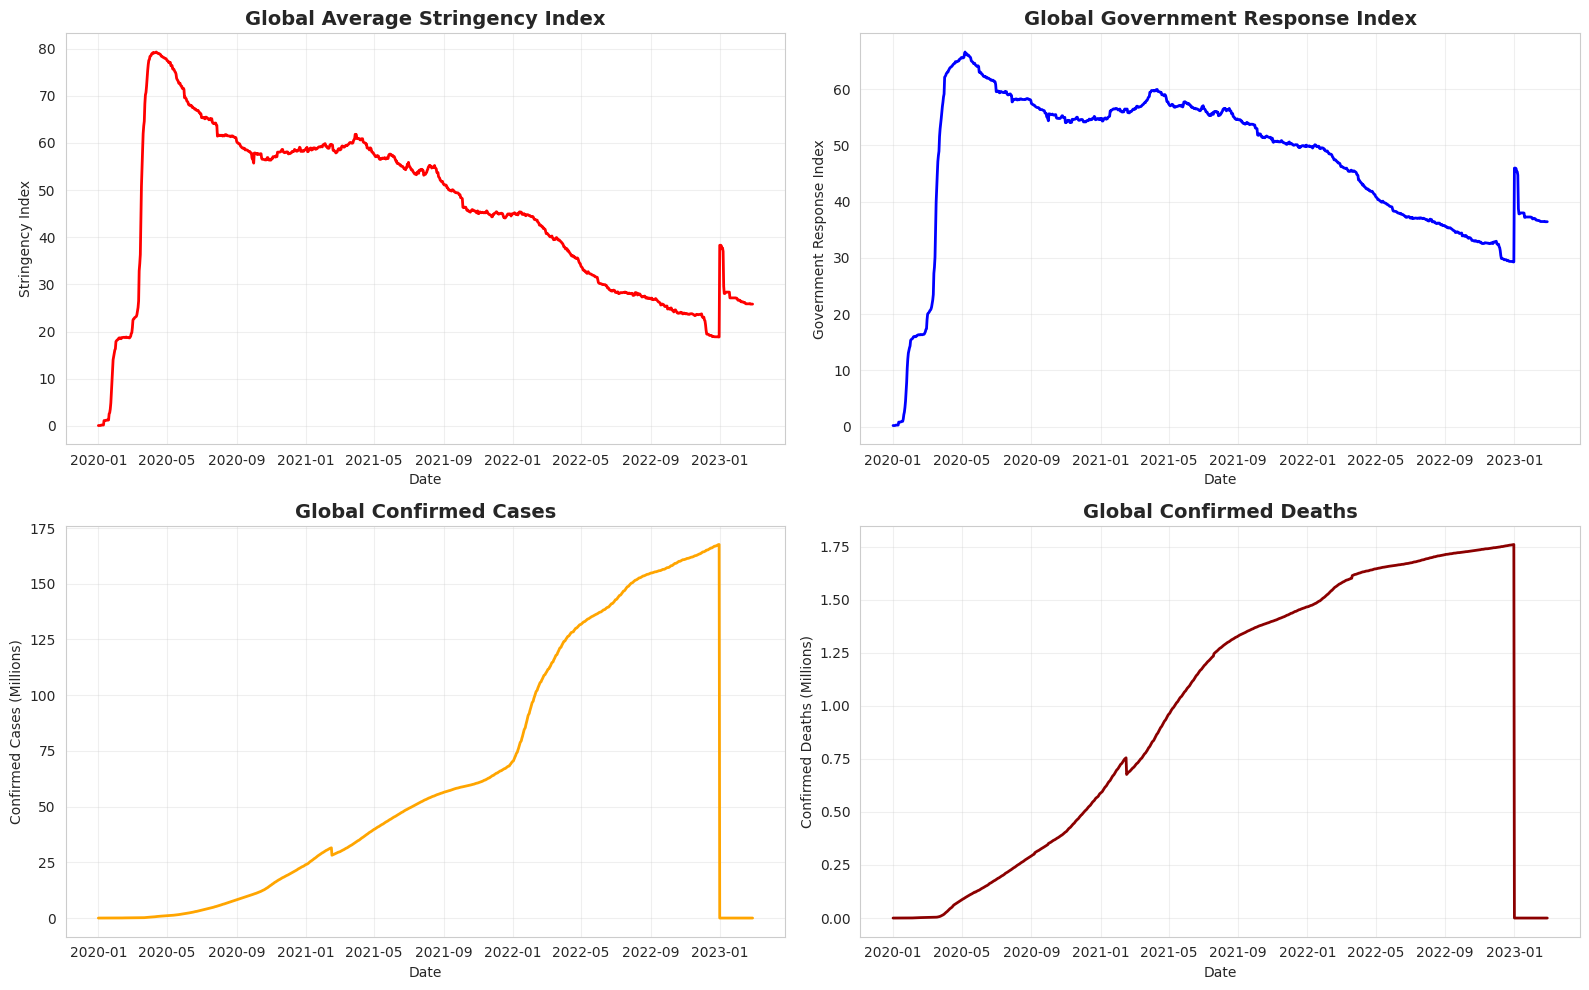

In [ ]:
plot_general_trends()

In [ ]:
# This function identifies countries with highest average stringency
# and also shows their mortality rates

def plot_strictest_countries():


    country_summary = df.groupby('CountryName').agg({
        'StringencyIndex': 'mean',
        'ConfirmedCases': 'max',
        'ConfirmedDeaths': 'max'
    }).reset_index()

    country_summary['MortalityRate'] = (country_summary['ConfirmedDeaths'] /
                                         country_summary['ConfirmedCases'] * 100)

    top_strict = country_summary.nlargest(10, 'StringencyIndex')


    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(top_strict['CountryName'], top_strict['StringencyIndex'], color='steelblue')
    plt.xlabel('Average Stringency Index', fontsize=12)
    plt.ylabel('Country', fontsize=12)
    plt.title('Top 10 Countries by Average Stringency Index', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()

    print("\nTop 10 Strictest Countries with Mortality Rates:")
    print(top_strict[['CountryName', 'StringencyIndex', 'ConfirmedDeaths', 'MortalityRate']])

    return plt



Top 10 Strictest Countries with Mortality Rates:
   CountryName  StringencyIndex  ConfirmedDeaths  MortalityRate
48     Eritrea        61.988330            103.0       1.010894
9   Azerbaijan        59.991551          10008.0       1.211034
52        Fiji        54.023741            881.0       1.282350
33       China        53.326987           5549.0       0.283681
5    Argentina        52.429097         130124.0       1.315561
10     Bahamas        52.295000            833.0       2.221867
4       Angola        51.621734           1930.0       1.836434
32       Chile        51.386925          63172.0       1.254028
19      Bhutan        50.683650             21.0       0.033587
34    Colombia        50.665146         141881.0       2.239050


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

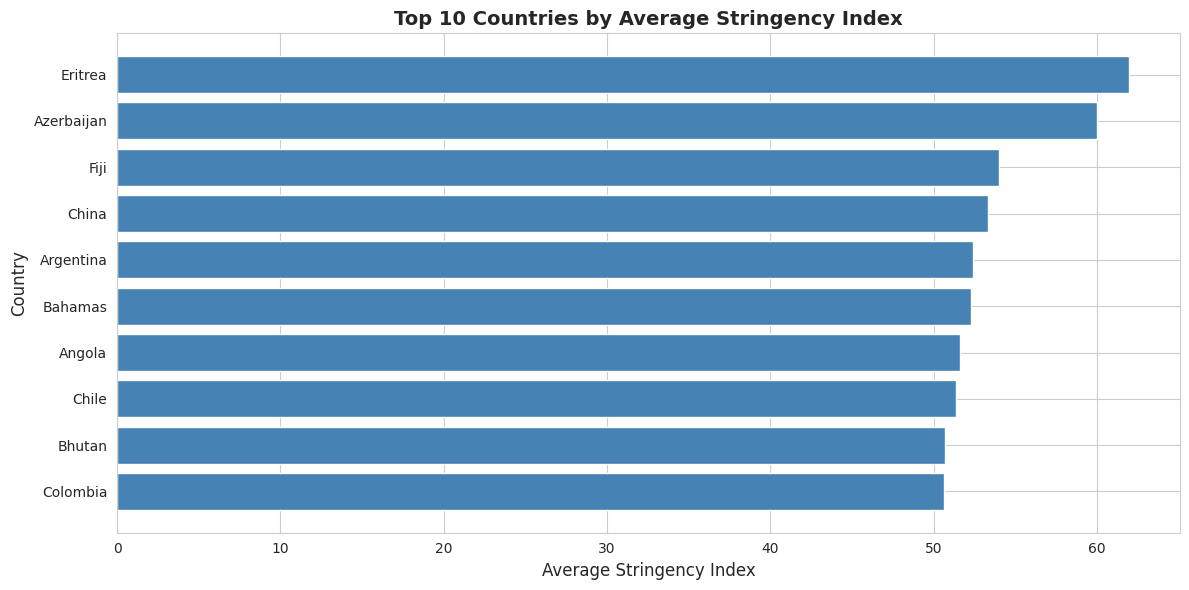

In [ ]:
plot_strictest_countries()

In [ ]:
# This function shows mortality rates for the strictest countries
# to see if high stringency correlated with lower mortality

def plot_strictest_countries_mortality():

    country_summary = df.groupby('CountryName').agg({
        'StringencyIndex': 'mean',
        'ConfirmedCases': 'max',
        'ConfirmedDeaths': 'max'
    }).reset_index()

    country_summary['MortalityRate'] = (country_summary['ConfirmedDeaths'] /
                                         country_summary['ConfirmedCases'] * 100)


    top_strict = country_summary.nlargest(10, 'StringencyIndex')

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(top_strict['CountryName'], top_strict['MortalityRate'], color='coral')
    plt.xlabel('Mortality Rate (%)', fontsize=12)
    plt.ylabel('Country', fontsize=12)
    plt.title('Mortality Rates of Top 10 Strictest Countries', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()

    print("\nTop 10 Strictest Countries vs Mortality ")
    print(top_strict[['CountryName', 'StringencyIndex', 'MortalityRate']].sort_values('MortalityRate', ascending=False))

    return plt



Top 10 Strictest Countries vs Mortality 
   CountryName  StringencyIndex  MortalityRate
34    Colombia        50.665146       2.239050
10     Bahamas        52.295000       2.221867
4       Angola        51.621734       1.836434
5    Argentina        52.429097       1.315561
52        Fiji        54.023741       1.282350
32       Chile        51.386925       1.254028
9   Azerbaijan        59.991551       1.211034
48     Eritrea        61.988330       1.010894
33       China        53.326987       0.283681
19      Bhutan        50.683650       0.033587


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

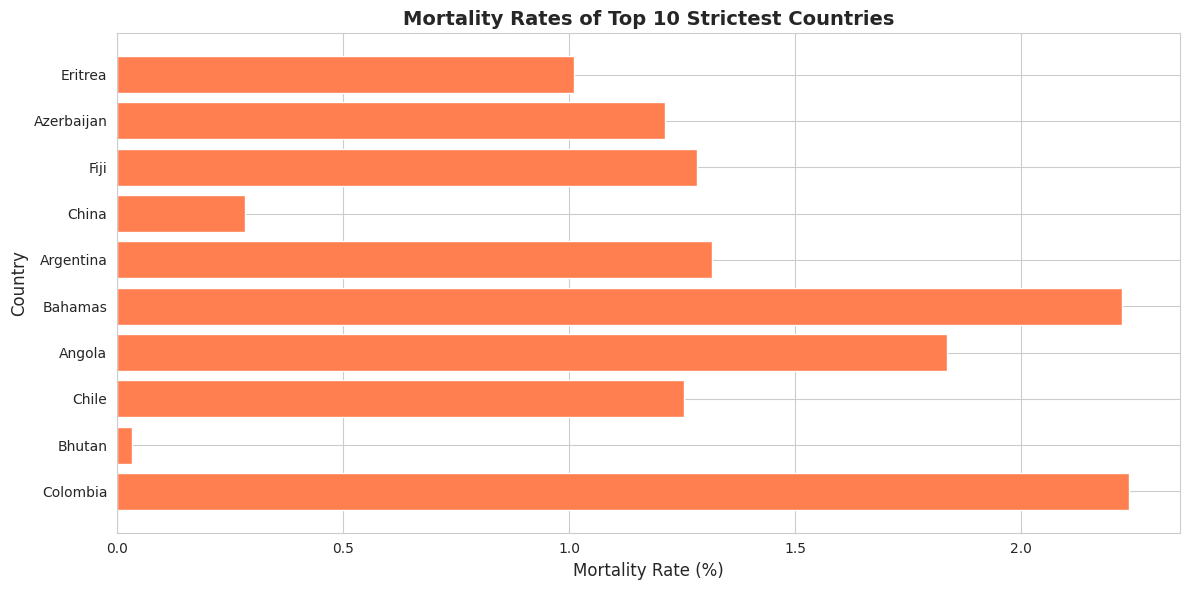

In [ ]:
plot_strictest_countries_mortality()

In [ ]:
#This function identifies countries with highest mortality rates
# and shows their stringency levels

def plot_high_mortality_countries():

    country_summary = df.groupby('CountryName').agg({
        'StringencyIndex': 'mean',
        'ConfirmedCases': 'max',
        'ConfirmedDeaths': 'max'
    }).reset_index()


    country_summary['MortalityRate'] = (country_summary['ConfirmedDeaths'] /
                                         country_summary['ConfirmedCases'] * 100)

    # Filter out countries with very low cases (less than 1000) for more reliable mortality rates
    country_summary = country_summary[country_summary['ConfirmedCases'] >= 1000]

    top_mortality = country_summary.nlargest(10, 'MortalityRate')

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(top_mortality['CountryName'], top_mortality['MortalityRate'], color='darkred')
    plt.xlabel('Mortality Rate (%)', fontsize=12)
    plt.ylabel('Country', fontsize=12)
    plt.title('Top 10 Countries by Mortality Rate', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()

    print("\nTop 10 Countries by Mortality Rate with their Stringency:")
    print(top_mortality[['CountryName', 'MortalityRate', 'StringencyIndex', 'ConfirmedDeaths']])

    return plt


Top 10 Countries by Mortality Rate with their Stringency:
               CountryName  MortalityRate  StringencyIndex  ConfirmedDeaths
47                   Egypt       4.809704        43.273038          24801.0
21  Bosnia and Herzegovina       4.046714        38.682710          16227.0
0              Afghanistan       3.781575        27.394580           7849.0
46                 Ecuador       3.454231        47.739261          35940.0
25                Bulgaria       2.949298        36.167573          38108.0
2                  Algeria       2.536980        48.367728           6881.0
34                Colombia       2.239050        50.665146         141881.0
10                 Bahamas       2.221867        52.295000            833.0
20                 Bolivia       1.920642        42.292920          22299.0
23                  Brazil       1.909795        47.183063         693853.0


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

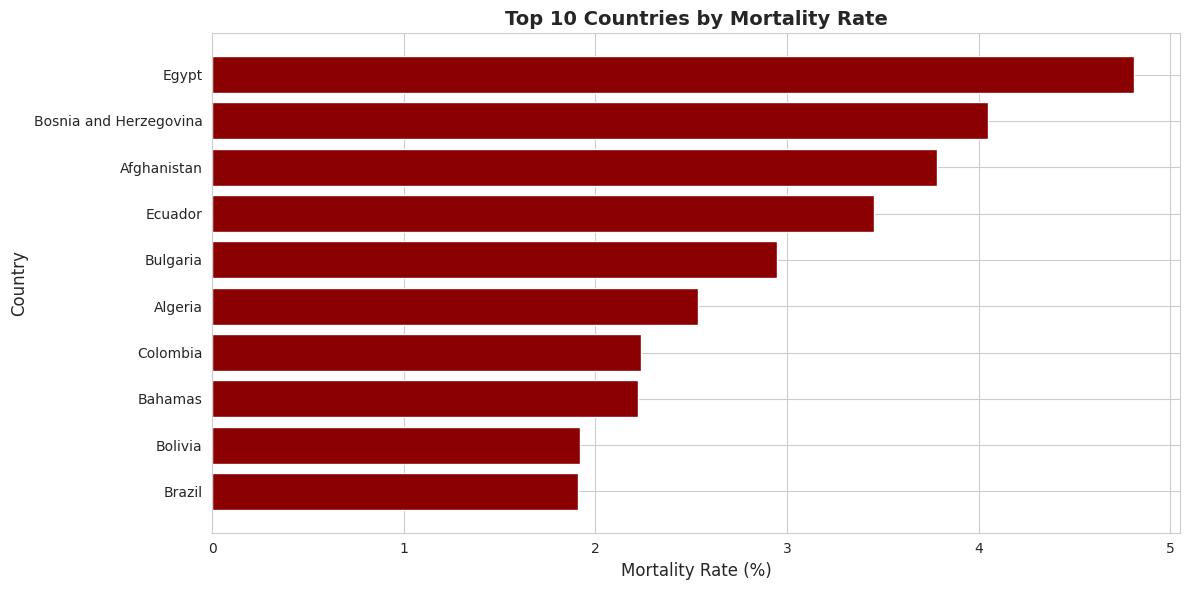

In [ ]:
plot_high_mortality_countries()

In [ ]:
# This function shows stringency levels for countries with highest mortality
# to see if high mortality countries were less strict

def plot_high_mortality_countries_stringency():

    country_summary = df.groupby('CountryName').agg({
        'StringencyIndex': 'mean',
        'ConfirmedCases': 'max',
        'ConfirmedDeaths': 'max'
    }).reset_index()


    country_summary['MortalityRate'] = (country_summary['ConfirmedDeaths'] /
                                         country_summary['ConfirmedCases'] * 100)


    country_summary = country_summary[country_summary['ConfirmedCases'] >= 1000]

    top_mortality = country_summary.nlargest(10, 'MortalityRate')


    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(top_mortality['CountryName'], top_mortality['StringencyIndex'], color='purple')
    plt.xlabel('Average Stringency Index', fontsize=12)
    plt.ylabel('Country', fontsize=12)
    plt.title('Stringency Levels of Top 10 High Mortality Countries', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()

    print("\nTop 10 High Mortality Countries:")
    print(top_mortality[['CountryName', 'MortalityRate', 'StringencyIndex']].sort_values('StringencyIndex', ascending=False))

    return plt



Top 10 High Mortality Countries:
               CountryName  MortalityRate  StringencyIndex
10                 Bahamas       2.221867        52.295000
34                Colombia       2.239050        50.665146
2                  Algeria       2.536980        48.367728
46                 Ecuador       3.454231        47.739261
23                  Brazil       1.909795        47.183063
47                   Egypt       4.809704        43.273038
20                 Bolivia       1.920642        42.292920
21  Bosnia and Herzegovina       4.046714        38.682710
25                Bulgaria       2.949298        36.167573
0              Afghanistan       3.781575        27.394580


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

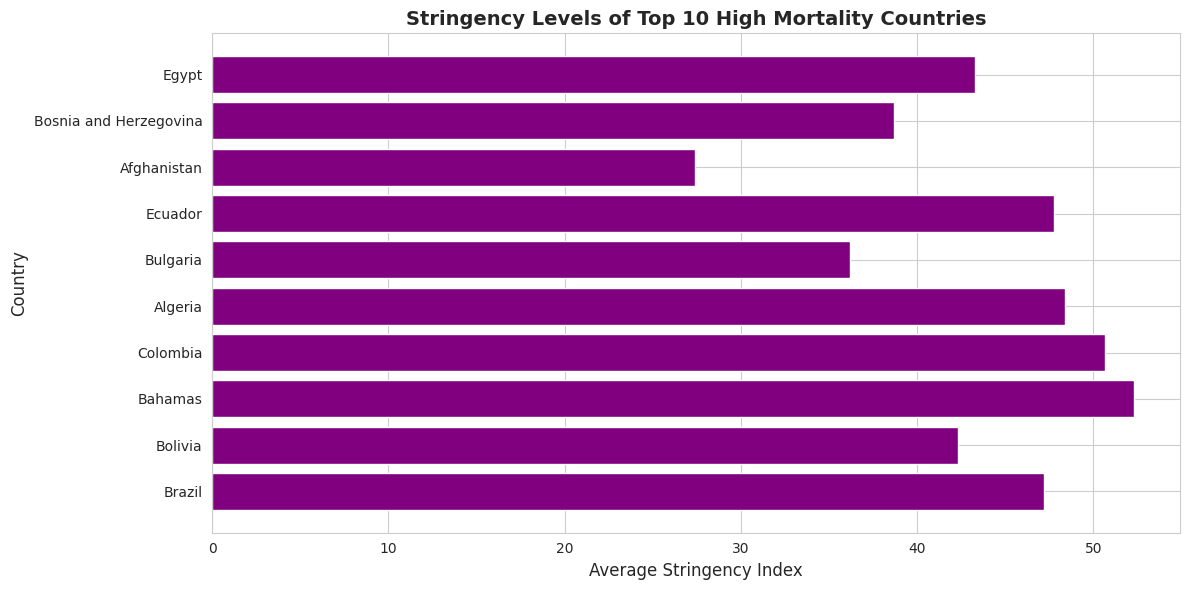

In [ ]:
plot_high_mortality_countries_stringency()

In [4]:
# This function filters data to January 1, 2020 - December 31, 2022
# and creates a new dataset for ML training

def create_filtered_dataset():

    df['DateISO'] = pd.to_datetime(df['DateISO'])

    filtered_covid_data = df[(df['DateISO'] >= '2020-01-01') &
                              (df['DateISO'] <= '2022-12-31')].copy()

    filtered_covid_data.to_csv('filtered_covid_data.csv', index=False)


    print(f"Original data: {len(df):,} records")
    print(f"Filtered data: {len(filtered_covid_data):,} records")
    print(f"Date range: {filtered_covid_data['DateISO'].min().date()} to {filtered_covid_data['DateISO'].max().date()}")
    print("\nSaved as: filtered_covid_data.csv")

    return filtered_covid_data


In [5]:


# Call the function to create filtered dataset
filtered_covid_data = create_filtered_dataset()

Original data: 456,225 records
Filtered data: 432,920 records
Date range: 2020-01-01 to 2022-12-31

Saved as: filtered_covid_data.csv



Peak Global Stringency: 79.16
Date of Peak: 2020-04-12


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

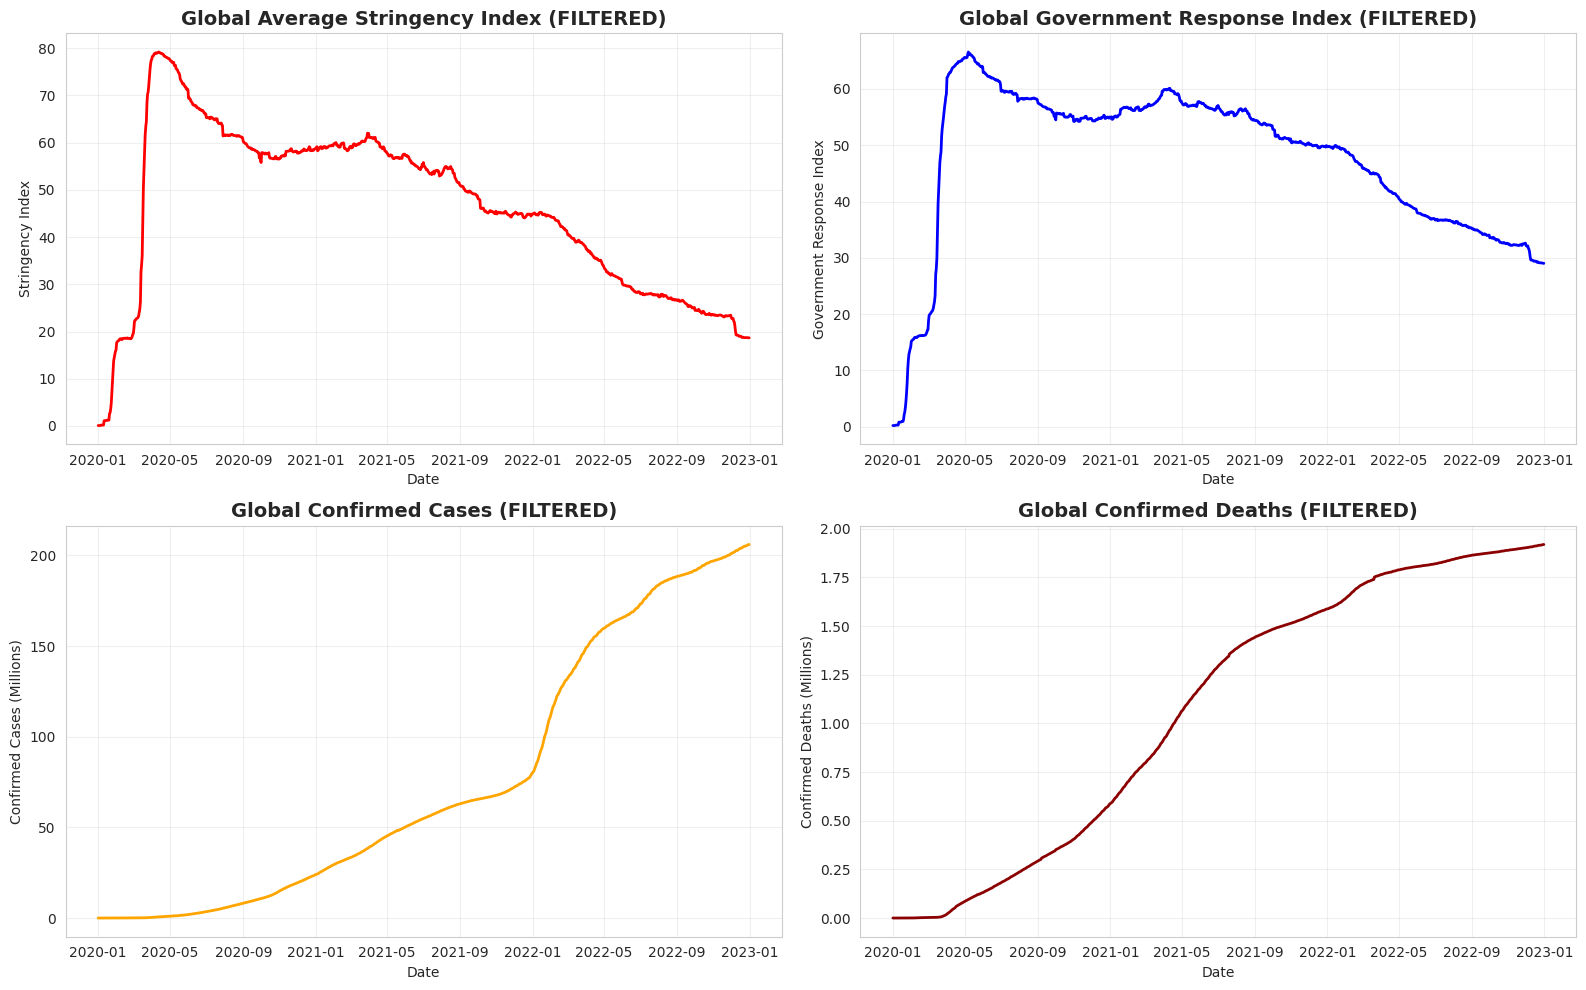

In [ ]:
# This function shows general trends for the FILTERED dataset

def plot_filtered_trends():


    global_daily = filtered_covid_data.groupby('DateISO').agg({
        'StringencyIndex': 'mean',
        'GovernmentResponseIndex': 'mean',
        'ConfirmedCases': 'sum',
        'ConfirmedDeaths': 'sum'
    }).reset_index()

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Plot 1: Stringency Index
    axes[0, 0].plot(global_daily['DateISO'], global_daily['StringencyIndex'],
                    linewidth=2, color='red')
    axes[0, 0].set_title('Global Average Stringency Index (FILTERED)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Stringency Index')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Government Response
    axes[0, 1].plot(global_daily['DateISO'], global_daily['GovernmentResponseIndex'],
                    linewidth=2, color='blue')
    axes[0, 1].set_title('Global Government Response Index (FILTERED)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Government Response Index')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Cases
    cases_in_millions = global_daily['ConfirmedCases'] / 1_000_000
    axes[1, 0].plot(global_daily['DateISO'], cases_in_millions,
                    linewidth=2, color='orange')
    axes[1, 0].set_title('Global Confirmed Cases (FILTERED)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Confirmed Cases (Millions)')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Deaths
    deaths_in_millions = global_daily['ConfirmedDeaths'] / 1_000_000
    axes[1, 1].plot(global_daily['DateISO'], deaths_in_millions,
                    linewidth=2, color='darkred')
    axes[1, 1].set_title('Global Confirmed Deaths (FILTERED)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Confirmed Deaths (Millions)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Calculate peak statistics
    peak_stringency = global_daily['StringencyIndex'].max() 
    peak_date = global_daily.loc[global_daily['StringencyIndex'].idxmax(), 'DateISO'].date()

    print(f"\nPeak Global Stringency: {peak_stringency:.2f}")
    print(f"Date of Peak: {peak_date}")

    return plt


plot_filtered_trends()

## Analysis

### Pipeline Overview
To answer the question of how we can minimize the negative effects of pandemics like COVID, and specifically to look for an optimal set of policy decisions, we decided to train two models effectively. 

The first of which is a pandemic simulation. This used the data from the dataset that would accurately predict outcomes, so these outcome variables included confirmed cases, confirmed deaths, etc., based off policy decisions. Under the hood, we used a linear ridge model in our final model, but we also tried experimenting with a LSTM, neural network, linear decay model, but found that the linear ridge model was the quickest to train, and therefore the best to experiment with, and gave us the best results. 

Once we had the simulation, we used the simulation to find a set of day-by-day policy decisions that were made in order to minimize bad outcomes. This included minimizing the amount of cases and deaths, while maximizing good outcomes, things like the proportion of people vaccinated. We also wanted to find policies that minimize strictness, so we wanted to find a minimum set of policies that a country could enact that will give you the best outcomes. The idea behind this was that stricter countries with stricter policies would obviously perform better, so we wanted to find a more nuanced set of policies.

We could have trained one large model that would accurately predict the outcomes of COVID due to policy decisions for all countries. However, doing so makes the assertion that other factors, such as geographical, cultural, and political factors, don't play a significant effect on the spread of an epidemic within a country. In essence, if we were to try to train one large supermodel, what we're saying is that epidemics spread similarly throughout all countries in the world. This is inherently untrue. 

Different countries have different cultures and different geographies, which result in epidemics spreading and being reported differently. Therefore, we needed to train an ensemble of models that would become experts on certain types of countries. Our final pipeline resulted in three steps. First is training clustering models, which cluster the countries based off how similar they are together, specifically in policy. Then, we used that to train an ensemble of regression models that acted as our simulation. Finally, we did a reinforcement learning model that chose an optimal set of policies.

### Note about Code & Figures

Throughout the development of our project, we had found that training times and development had become sluggish using the Jupyter notebook. We desired something with version control, and therefore we had moved at some point to using a local enviornment with an IDE and Git. We made this decision before learning that the final report would be a part of a Jupyter notebook. Therefore, a lot of our code, including the sections about simulation, manual policy exploration, super agent policy exploration, and reinforcement learning policy exploration, were ran and developed locally. 

As a side effect of this, the static rendering of the Jupyter notebook doesn't represent the actual output of our code. Doing so would require re-running these code blocks, which would actually took over 30 hours total, and also re-plotting the hundreds of graphs produced. Instead, we have provided the code, slightly transformed to work in a Jupyter notebook, but the actual figures are stored in the [Google Drive](https://drive.google.com/drive/u/0/folders/1A4oQIqNkmyd7zEfFCe2ox797f2RqjS5O). The code does not work out of the box in the Jupyter notebook, rather needs some modules, which are a part of our GitHub repository linked [here](https://github.com/Evan-Bertis-Sample/cs326-final). All insights and analysis were made from these figures in the google drive.

### Clustering

We used StandardScaler to scale the features because K-Means uses Euclidean distance, so features need the same scale. Our policy features have different ranges (school closing: 0-3, masks: 0-4). So we use StandardScaler to normalize all features to z-scores (mean=0, std=1), ensuring each feature contributes equally to clustering.
A core assumption we wanted to challenge was that all countries behave similarly during a pandemic. In reality, countries differ in geography, culture, healthcare infrastructure,of which affect how pandemics spread and how effective policies are. Training a single regression model on allcountries would ignore these differences and assume uniform behavior across diverse
contexts. To address this, we used K-Means clustering to group countries with similar policy
patterns. 
We tested 7 different policy groupings: For each grouping, we tested K=4, 5, 6, and 7 clusters and evaluated quality using two metrics:
Silhouette Score and Balance.


#### Clustering Code

In [13]:


def prepare_oxcgrt_features():


    containment_features = [
        'C1M_School closing',
        'C2M_Workplace closing',
        'C3M_Cancel public events',
        'C4M_Restrictions on gatherings',
        'C5M_Close public transport',
        'C6M_Stay at home requirements',
        'C7M_Restrictions on internal movement',
        'C8EV_International travel controls'
    ]


    economic_ordinal = ['E1_Income support', 'E2_Debt/contract relief']
    economic_numeric = ['E3_Fiscal measures', 'E4_International support']


    health_ordinal = [
        'H1_Public information campaigns',
        'H2_Testing policy',
        'H3_Contact tracing',
        'H6M_Facial Coverings',
        'H7_Vaccination policy',
        'H8M_Protection of elderly people'
    ]
    health_numeric = [
        'H4_Emergency investment in healthcare',
        'H5_Investment in vaccines'
    ]


    all_features = (containment_features + economic_ordinal + economic_numeric +
                    health_ordinal + health_numeric)
    available_features = [f for f in all_features if f in filtered_covid_data.columns]


    # Calculate country averages
    country_data = filtered_covid_data.groupby('CountryName')[available_features].mean().reset_index()

    # Add outcomes
    outcome_data = filtered_covid_data.groupby('CountryName').agg({
        'ConfirmedCases': 'max',
        'ConfirmedDeaths': 'max'
    }).reset_index()

    country_data = country_data.merge(outcome_data, on='CountryName')


    country_data['CaseFatalityRate'] = (
        country_data['ConfirmedDeaths'] / country_data['ConfirmedCases'] * 100
    )


    country_data = country_data.dropna()

    print(f"\nCountries with complete data: {len(country_data)}")

    return country_data, available_features


country_data_oxcgrt, oxcgrt_features = prepare_oxcgrt_features()

NameError: name 'filtered_covid_data' is not defined

In [ ]:


def test_oxcgrt_combinations():
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import silhouette_score

    feature_combinations = {
        'Containment Only': [
            'C1M_School closing', 'C2M_Workplace closing',
            'C3M_Cancel public events', 'C4M_Restrictions on gatherings',
            'C5M_Close public transport', 'C6M_Stay at home requirements',
            'C7M_Restrictions on internal movement', 'C8EV_International travel controls'
        ],

        'Containment + Health': [
            'C1M_School closing', 'C2M_Workplace closing',
            'C6M_Stay at home requirements', 'C8EV_International travel controls',
            'H1_Public information campaigns', 'H2_Testing policy',
            'H3_Contact tracing', 'H6M_Facial Coverings'
        ],

        'Containment + Economic': [
            'C1M_School closing', 'C2M_Workplace closing',
            'C6M_Stay at home requirements',
            'E1_Income support', 'E2_Debt/contract relief'
        ],

        'Health Only': [
            'H1_Public information campaigns', 'H2_Testing policy',
            'H3_Contact tracing', 'H6M_Facial Coverings',
            'H7_Vaccination policy', 'H8M_Protection of elderly people'
        ],

        'Strict Policies (High Impact)': [
            'C1M_School closing', 'C2M_Workplace closing',
            'C6M_Stay at home requirements', 'H6M_Facial Coverings'
        ],

        'Full Policy Response': [
            'C1M_School closing', 'C2M_Workplace closing',
            'C6M_Stay at home requirements', 'C8EV_International travel controls',
            'E1_Income support', 'H2_Testing policy',
            'H3_Contact tracing', 'H6M_Facial Coverings'
        ],

        'Policies + Outcomes': [
            'C1M_School closing', 'C2M_Workplace closing',
            'C6M_Stay at home requirements', 'H2_Testing policy',
            'H6M_Facial Coverings', 'CaseFatalityRate'
        ]
    }



    results = []

    for combo_name, features in feature_combinations.items():

        available = [f for f in features if f in country_data_oxcgrt.columns]

        if len(available) < 3:
            print(f"\n{combo_name}: Not enough features available")
            continue

        print(f"\n{combo_name}:")
        print(f"  Using {len(available)} features: {available[:4]}...")


        X = country_data_oxcgrt[available].values

        scaler = StandardScaler()
        X_norm = scaler.fit_transform(X)

        # Test different K values
        for k in [4, 5, 6, 7]:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
            labels = kmeans.fit_predict(X_norm)


            silhouette = silhouette_score(X_norm, labels)
            unique, counts = np.unique(labels, return_counts=True)
            balance = counts.max() / counts.min()

            results.append({
                'Combination': combo_name,
                'Num_Features': len(available),
                'K': k,
                'Silhouette': silhouette,
                'Balance': balance,
                'Min_Size': counts.min(),
                'Max_Size': counts.max(),
                'Sizes': sorted(counts.tolist())
            })

            print(f"    K={k}: Silhouette={silhouette:.3f}, Balance={balance:.2f}x, Sizes={sorted(counts.tolist())}")

    # Convert to dataframe
    results_df = pd.DataFrame(results)

    results_df['Score'] = results_df['Silhouette'] - (results_df['Balance'] * 0.2)
    results_df = results_df.sort_values('Score', ascending=False)

    print("TOP 10 combos:")

    print(results_df.head(10)[['Combination', 'K', 'Silhouette', 'Balance', 'Sizes']].to_string(index=False))

    return results_df, feature_combinations


oxcgrt_results, oxcgrt_combinations = test_oxcgrt_combinations()

: 

In [ ]:
# This function does clustering and saves results
def full_policy_clustering_and_save():
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans


    features = [
        'C1M_School closing', 'C2M_Workplace closing',
        'C6M_Stay at home requirements', 'H6M_Facial Coverings'
    ]

    # Get country averages
    country_data = filtered_covid_data.groupby('CountryCode')[features].mean().reset_index()
    country_data = country_data.dropna()

    print(f"Countries: {len(country_data)}")

    X = country_data[features].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    kmeans = KMeans(n_clusters=5, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_scaled)

    country_data['Cluster'] = labels

    print("\nCluster sizes:")
    print(country_data['Cluster'].value_counts().sort_index())

    # Save each cluster to separate text file
    for cluster_id in range(5):
        cluster_countries = country_data[country_data['Cluster'] == cluster_id]['CountryCode'].tolist()

        cluster_countries.sort()

        filename = f'cluster_{cluster_id + 1}.txt'
        with open(filename, 'w') as f:
            for country in cluster_countries:
                f.write(country + '\n')

    return country_data



: 

In [18]:
full_policy_clustering_and_save()

Countries: 185

Cluster sizes:
Cluster
0    38
1    27
2    23
3    41
4    56
Name: count, dtype: int64


,CountryCode,C1M_School closing,C2M_Workplace closing,C6M_Stay at home requirements,H6M_Facial Coverings,Cluster
0,ABW,0.768248,0.973540,0.660584,1.792883,1
1,AFG,0.928832,1.486314,0.321168,2.225365,4
2,AGO,0.812956,1.875912,0.908759,2.775547,3
3,ALB,1.250000,1.194343,1.164234,2.314781,3
4,AND,0.784672,1.102190,0.133212,2.178832,1
...,...,...,...,...,...,...
180,VUT,0.489964,0.559307,0.268248,0.571168,2
181,YEM,0.819343,0.638686,1.243613,0.707117,2
182,ZAF,0.959854,1.204380,1.137774,2.084854,3
183,ZMB,0.797445,0.750000,0.134124,2.703467,1


#### Results 

The "Strict Policies " feature set with K=5 produced the best results:
- Features: C1M_School closing, C2M_Workplace closing, C6M_Stay at home requirements, H6M_Facial Coverings
- Silhouette Score: 0.232 
- Balance: 2.45x 
- Cluster sizes: 38, 27, 23, 41, 56 countries
The clustering captured real policy behavior patterns rather than just geographic or economic similarities.

### Simulation

#### Intuition

To create our simulation model, we had to put a lot of thought into what exactly are the inputs and outputs of the function that we're approximating. We found a sequence model to be the best fit. The idea behind this is it most closely mirrors how policymakers would actually make decisions. Under the hood, the model takes some information about the past few days of a country, that includes the policy decisions that the country has made, the outcomes and the effects that we're trying to minimize, and then tries to predict the next day. This closely mirrors how we as governments respond to pandemics on a reactive basis. 

Mathematically, our model is doing is it's taking three main parameters. One is a vector of meta information about the country. So this is a simple vector with a one-shot encoding of the country name, region code, and other information found in our dataset. It also takes in two lists of vectors. One of the lists of vectors are policy decisions. In our dataset, we have multiple columns of policy decisions, and each of them have an intensity. An intensity of zero either means that there's no data collected about this or the policy wasn't enforced, whereas higher numbers indicate higher strictness. Then similarly, it takes in a list of vectors, including outcomes. The width of both this outcome and policy list are the exact same. This width is how many days of prior information a model has to make it's prediction. 

With this information, the model answers the question, "what is the next day in the sequence?" We train this model to minimize the error with that prediction of the next day versus what actually happened in the next day. 

To use the simulation, you would simply change what the policy decisions a country has made to generate a new sequence of days.

There are a lot of hyperparameters when training a sequence model, outside of the model-specific ones. One of which is the window size, which determines how many days of policy decisions and outcomes does a model get to see before predicting the next day in the sequence. We didn't have an intuitive sense on what the best window size is, so we decided to experiment training a bunch of models with different window sizes with a bunch of different hyperparameters using a grid search in order to figure out what is the best possible window size.

Creating training and test splits for this dataset required a different approach than a standard row-level split. Rather than randomly dividing all rows across training and testing, we split the data at the country level. All rows corresponding to a given country were grouped together, and these country-level buckets were assigned to either the training or test set. The goal was for the model to learn the full trajectory—policies, outcomes, and dynamics—of each country in the training data, and then be evaluated on its ability to simulate an entirely new country from start to finish.

One hyperparameter we had to optimize was how many days of data the model should be allowed to train on within a country. In principle, we could train on every single day in the dataset (day 0, day 1, day 2, etc.), but doing so risked overfitting. To address this, we introduced an additional hyperparameter called maxGeosPerCountry, which determines how many days of data per country the model is allowed to see during training.

These selected days were evenly distributed across the full timeline. In other words, the model received a representative sample from the beginning, middle, and end of each country’s time series, ensuring broad coverage without overfitting to every small fluctuation in the data.

#### Simulation Training Code

This code was initially ran and developed locally. It uses modules that we made that are not contained in the notebook.

In [17]:
from __future__ import annotations
from pathlib import Path
import argparse
import json
import hashlib
from typing import Dict, Any, Tuple
from joblib import dump
import os

from analysis.config import AnalysisConfig
from analysis.cache import Cache, CacheConfig
import analysis.procs as procs

## ARTIFACT FROM THIS BEING A CLI TOOL
def parse_args(args = None):
    p = argparse.ArgumentParser()
    p.add_argument(
        "--invalidate",
        nargs="*",
        default=[],
        help="Block names to invalidate inside the cache.",
    )
    p.add_argument(
        "--no-cascade-up",
        action="store_true",
        help="Do NOT cascade upward when invalidating blocks.",
    )
    p.add_argument(
        "--force",
        action="store_true",
        help="Skip confirmation prompt when invalidating.",
    )
    p.add_argument(
        "--print-only",
        action="store_true",
        help="Show chains/targets without deleting.",
    )
    p.add_argument(
        "--clusters-dir",
        default="data/clusters",
        help="Directory containing cluster files (one GeoID per line).",
    )
    p.add_argument(
        "--verbose-cache", action="store_true", help="Cache logging enabled."
    )
    p.add_argument(
        "--debug",
        action="store_true",
        help="Run only a small subset (window_size=14, geo_max=100) for quick debugging.",
    )
    return p.parse_args(args)


def init_cache(args):
    cache_root = AnalysisConfig.paths.cache
    Cache.init(
        CacheConfig(root=cache_root, compress=3, default_verbose=args.verbose_cache)
    )
    for blk in args.invalidate:
        Cache.invalidate_block(
            blk,
            cascade_up=not args.no_cascade_up,
            force=args.force,
            print_only=args.print_only,
        )
    print(f"Cache initialized at: {cache_root}\n")


def _discover_cluster_files(clusters_dir: Path) -> list[Path]:
    if not clusters_dir.exists():
        return []
    files = [
        p for p in clusters_dir.iterdir() if p.is_file() and not p.name.startswith(".")
    ]
    return sorted(files, key=lambda p: p.name.lower())


def _hp_hash(params: Dict[str, Any]) -> str:
    s = json.dumps(params or {}, sort_keys=True)
    return hashlib.sha1(s.encode("utf-8")).hexdigest()[:10]


def _serialize_model_once(model, model_dir: Path, params: Dict[str, Any]) -> Path:
    model_name = model.name()
    h = _hp_hash(params)
    out_dir = Path("models") / model_name
    out_dir.mkdir(parents=True, exist_ok=True)

    model_path = out_dir / f"{model_name}_{h}.joblib"
    if not model_path.exists():
        dump(model, model_path, compress=3)

        # save hyperparameters next to it
        (out_dir / f"hyperparameters_{h}.json").write_text(
            json.dumps(params or {}, indent=2, ensure_ascii=False),
            encoding="utf-8",
        )
    return model_path


def train_sim(args = None):
    args = parse_args(args)
    init_cache(args)

    clusters_dir = Path(args.clusters_dir)
    cluster_files = _discover_cluster_files(clusters_dir)

    if not cluster_files:
        print(f"No cluster files found in: {clusters_dir}")
        return

    print(
        f"Found {len(cluster_files)} cluster file(s) in {clusters_dir}:\n"
        + "\n".join(f"  - {p.name}" for p in cluster_files)
        + "\n"
    )

    if args.debug:
        window_sizes = [14]
        geo_max_values = [100]
    else:
        window_sizes = range(3, 21, 5)
        geo_max_values = range(100, 599, 100)

    # Best-per-Geo accumulator across all (cluster, window, geo_max) runs
    # geo -> (rmse, mae, model, params)
    best_for_geo: Dict[str, Tuple[float, float, Any, Dict[str, Any]]] = {}

    Cache.Begin("training")
    try:
        for cfile in cluster_files:
            for window_size in window_sizes:
                for geo_max in geo_max_values:
                    cluster_name = cfile.stem
                    block_name = f"train_{cluster_name}_window_size_{window_size}_geo_max_{geo_max}"

                    Cache.Begin(block_name)
                    try:
                        best_model, best_params, best_metrics, geos = (
                            procs.handle_models(
                                cluster_file=cfile,
                                window=window_size,
                                horizon=1,
                                max_per_geo=geo_max,
                            )
                        )
                        # Assign this run's best model to all geos in the cluster if it's an improvement
                        for gid in geos:
                            prev = best_for_geo.get(gid)
                            key = (best_metrics.rmse, best_metrics.mae)
                            if (prev is None) or (key < (prev[0], prev[1])):
                                best_for_geo[gid] = (
                                    best_metrics.rmse,
                                    best_metrics.mae,
                                    best_model,
                                    best_params,
                                )
                    finally:
                        Cache.End()
    finally:
        Cache.End()

    model_file_cache: Dict[Tuple[str, str], Path] = {}  # (model_name, hp_hash) -> path
    final_map: Dict[str, Dict[str, str]] = {}  # GeoID -> {model_name, model_file}

    for gid, (rmse, mae, model, params) in best_for_geo.items():
        model_name = model.name()
        h = _hp_hash(params)
        key = (model_name, h)
        if key not in model_file_cache:
            model_path = _serialize_model_once(
                model, Path("models") / model_name, params
            )
            model_file_cache[key] = model_path
        else:
            model_path = model_file_cache[key]

        final_map[gid] = {
            "model_name": model_name,
            "model_file": str(model_path.as_posix()),
        }

    # Save mapping
    mapping_path = Path("models") / "model_map.json"
    mapping_path.parent.mkdir(parents=True, exist_ok=True)
    mapping_path.write_text(
        json.dumps(final_map, indent=2, ensure_ascii=False), encoding="utf-8"
    )

    # Print compact summary
    print("\nFinal GeoID → Model mapping (first 50 entries):")
    for i, (gid, rec) in enumerate(final_map.items()):
        print(f"  {gid:20s} -> {rec['model_name']}  ({rec['model_file']})")

    print(f"\nSaved mapping to {mapping_path}")

In [20]:
train_sim([])

Loading config...
Cache initialized at: cache

Found 5 cluster file(s) in data\clusters:
  - cluster_auto_1.txt
  - cluster_auto_2.txt
  - cluster_auto_3.txt
  - cluster_auto_4.txt
  - cluster_auto_5.txt

[_search_model_hyperspace] Begin
[_search_model_hyperspace] model = <linear_window_ridge(l2=0.001, use_meta=True, filter_type=none, filter_alpha=...


Grid[linear_window_ridge]: 100%|██████████| 216/216 [00:07<00:00, 29.76cfg/s]


[_search_model_hyperspace] Complete — took 7.298s

[linear_window_ridge] final test: rmse=370.2090  mae=240.8707  r2=0.9984
[plot_all] Begin
[plot_all] self = <analysis.plotting.ModelGrapher object at 0x000001A91EEC19C0>


KeyboardInterrupt: 

**Note:** When ran locally, this exploration of models took 12+ hours and output not entirely useful prints.

For the purposes of this report, we are not rerunning the training, as we have the serialized models and the map for ensembling already created from the script.

Part of this script also generates a lot of plots, which were saved and uploaded to this [drive](https://drive.google.com/drive/u/0/folders/1WkQJikV1hfwah4dU-JQP5d9C3G0e2orL), under `figures`.

#### Results

After running this bit of code, a JSON file and a set of serialized models are saved to disk, which we use for our policy exploration. The JSON file maps a country region code to a serialized version of the model that best represents that country. 

We found that our models were really good at explaining the variance within our testing sets. We found that R2s were generally above 0.99 and our RSME was generally around 1,000. This is great as our case rate and deaths are often in the millions, so proportionally our RSME is very low. 

We also found that the models could get pretty unstable, so another hyperparameter we had to introduce for all models was a rolling filter. This filter ensured that the model could not overfit to certain spikes in the data as those spikes would kind of be suppressed by the filter.

One of the many artifacts of this script is a 3D plot of how different characteristics of a model, like the R2, RSME, MAE, etc., are affected by our problem-specific hyperparameters, which are the window size and the max geo per country. 

We're able to see that generally a larger window size in the order of around two weeks is generally preferred for these models. Anything larger kind of causes instability as well as longer training times, The models like to see around 400 of the days in the training day, which is interesting because seeing all the days actually causes it to be overfitting and not generalizable to newer countries.

In addition to these three plots, this script also generates a bunch of time series plots that show how the outcomes of different countries are being predicted. It showcases what the country actually witnessed versus the predictions of our models, as well as the difference between the two.

Looking through these time series graphs shows our model is kind of bad at making predictions of outcomes that jump rapidly. Oftentimes it under- or overshoots these predictions, but is generally stable when you have a decently constant rate of change on outcome variables. 

This worried us going into our next step, where we believed that this instability of these simulation models would not allow for us to extract useful insights. However, we were able to add additional filtering in the simulations in the next section that allowed us to extract some useful information.

### Manual Policy Exploration

#### Intution

Once we have the simulation models, we decided to begin manually exploring with different policies. This would give us an idea of what policies were most important, as well as general trends with the strictness versus laxness of policies. The script below runs a simulation of a country from day 100 to day 465. We found that starting our simulations in January 2020 generally led to pretty unstable outcomes, likely because of the limitations of our simulation model, and starting about three months in generally led to good results. Running it for more than two years made the reinforcement learning take forever to learn the best policies for one country, so we limited it per year because of time requirements.

During our manual policy exploration, we tested several types of agents: one that applied the strictest possible policies, one that used the most lenient policies, and another that began with very strict policies and gradually relaxed them over time. Comparing strict versus lax policy regimes served as an important sanity check for our simulation models. As expected, we anticipated that strict policy environments would produce better health outcomes, while highly lax environments would lead to worse outcomes.

#### Manual Policy Exploration Code

In [21]:
from __future__ import annotations

import argparse
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import pandas as pd

from analysis.config import AnalysisConfig
from analysis.oxcgrt_data import OxCGRTData
from analysis.fwd import ModelForwarder
from analysis.rl import RLSimulator, RelaxationAgent
from analysis.rl_eval import plot_outcomes, plot_reward, plot_differences, plot_policy_decisions
from analysis.agents.strict_policy import StrictPolicyAgent
from analysis.agents.lax_policy import LaxPolicyAgent

# ARTIFACT OF THIS ONCE BEING A CLI TOOL
def parse_args(argv = None) -> argparse.Namespace:
    p = argparse.ArgumentParser(
        description="RL-style simulation using pretrained COVID models."
    )
    p.add_argument(
        "--geos",
        nargs="+",
        required=True,
        help="GeoIDs to simulate (e.g. USA CHN ITA).",
    )
    p.add_argument(
        "--start-index",
        type=int,
        default=60,
        help="Index of the first prediction day in the per-geo time series.",
    )
    p.add_argument(
        "--steps",
        type=int,
        default=60,
        help="Number of simulated steps (days) per geo.",
    )
    p.add_argument(
        "--output-dir",
        type=str,
        default="figures/rl",
        help="Directory to store plots and stats.",
    )
    return p.parse_args(argv)


def build_agents() -> Dict[str, Any]:
    policy_cols = AnalysisConfig.metadata.policy_columns

    agents: Dict[str, Any] = {
        "strict": StrictPolicyAgent(policy_cols),
        "lax" : LaxPolicyAgent(policy_cols),
        "relax_0.9": RelaxationAgent(scale=0.9),
        "relax_0.8": RelaxationAgent(scale=0.8),
    }
    return agents


def compute_episode_stats(agent_name: str, ep) -> Dict[str, Any]:
    md = AnalysisConfig.metadata
    outcome_cols = md.outcome_columns

    n_steps = len(ep.steps)
    if n_steps == 0:
        return {
            "agent": agent_name,
            "geo": ep.geo_id,
            "n_steps": 0,
        }

    reward_actual = np.array([s.reward_actual for s in ep.steps], dtype=float)
    reward_sim = np.array([s.reward_simulated for s in ep.steps], dtype=float)

    row: Dict[str, Any] = {
        "agent": agent_name,
        "geo": ep.geo_id,
        "n_steps": n_steps,
        "reward_actual_mean": float(np.nanmean(reward_actual)),
        "reward_sim_mean": float(np.nanmean(reward_sim)),
        "reward_delta_mean": float(np.nanmean(reward_sim - reward_actual)),
    }

    y_true = np.stack([s.y_true for s in ep.steps], axis=0)
    y_pred = np.stack([s.y_pred for s in ep.steps], axis=0)

    for i, col in enumerate(outcome_cols):
        if i >= y_true.shape[1] or i >= y_pred.shape[1]:
            continue
        delta = y_pred[:, i] - y_true[:, i]  # sim - actual
        row[f"{col}_delta_mean"] = float(np.nanmean(delta))

    return row


def sim(argv = None) -> None:
    args = parse_args(argv)

    # Load analysis config and data
    cfg = AnalysisConfig
    data_path = cfg.paths.data

    print(f"Loading OxCGRT data from {data_path}...")
    data = OxCGRTData(data_path)

    # Forwarder and RL simulator
    forwarder = ModelForwarder(data=data)
    sim = RLSimulator(data=data, forwarder=forwarder)

    # Build all agents
    agents = build_agents()
    out_dir = Path(args.output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    stats_rows: List[Dict[str, Any]] = []

    for agent_name, agent in agents.items():
        print(f"\nRunning agent: {agent_name}")
        agent_dir = out_dir / agent_name

        for geo in args.geos:
            print(f"\nSimulating geo: {geo} with agent {agent_name}")
            ep = sim.simulate_episode(
                geo_id=geo,
                agent=agent,
                start_index=args.start_index,
                n_steps=args.steps,
            )

            geo_dir = agent_dir / f"{args.start_index}_to_{args.start_index + args.steps}" / geo
            plot_outcomes(ep, agent_name, output_dir=geo_dir)
            plot_reward(ep, agent_name, output_dir=geo_dir)
            plot_differences(ep, agent_name, output_dir=geo_dir)
            plot_policy_decisions(ep, cfg.metadata.policy_columns, agent_name, geo_dir)

            # Collect stats for this (agent, geo) pair
            stats_row = compute_episode_stats(agent_name, ep)
            stats_rows.append(stats_row)

            print(f"Plots saved under {geo_dir}")
            print("")

    # Save stats
    if stats_rows:
        stats_df = pd.DataFrame(stats_rows)
        stats_path = out_dir / "agent_geo_stats.csv"
        stats_df.to_csv(stats_path, index=False)
        print(f"\nPer-geo stats saved to {stats_path}")

        # Aggregate per agent
        agg_df = stats_df.groupby("agent").mean(numeric_only=True).reset_index()
        agg_path = out_dir / "agent_stats_overall.csv"
        agg_df.to_csv(agg_path, index=False)
        print(f"Per-agent aggregated stats saved to {agg_path}")

    print("\nDone.")


In [22]:
geos = ["USA", "AUS", "BEL", "SWE", "ZMB"]

for geo in geos:
    sim([
        "--geo", geo,
        "--start-index", "100",
        "--steps", "365",
    ])

Loading OxCGRT data from data\oxcgrt_tidy.csv...

Running agent: strict

Simulating geo: USA with agent strict


Simulating: 100%|██████████| 365/365 [00:17<00:00, 20.36day/s]


Error plotting policy E2_Debt/contract relief for agent strict
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent strict
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent strict
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent strict
Plots saved under figures\rl\strict\100_to_465\USA


Running agent: lax

Simulating geo: USA with agent lax


Simulating: 100%|██████████| 365/365 [00:18<00:00, 19.41day/s]


Error plotting policy E2_Debt/contract relief for agent lax
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent lax
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent lax
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent lax
Plots saved under figures\rl\lax\100_to_465\USA


Running agent: relax_0.9

Simulating geo: USA with agent relax_0.9


Simulating: 100%|██████████| 365/365 [00:19<00:00, 18.85day/s]


Error plotting policy E2_Debt/contract relief for agent relax_0.9
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent relax_0.9
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent relax_0.9
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent relax_0.9
Plots saved under figures\rl\relax_0.9\100_to_465\USA


Running agent: relax_0.8

Simulating geo: USA with agent relax_0.8


Simulating: 100%|██████████| 365/365 [00:20<00:00, 17.89day/s]


Error plotting policy E2_Debt/contract relief for agent relax_0.8
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent relax_0.8
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent relax_0.8
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent relax_0.8
Plots saved under figures\rl\relax_0.8\100_to_465\USA


Per-geo stats saved to figures\rl\agent_geo_stats.csv
Per-agent aggregated stats saved to figures\rl\agent_stats_overall.csv

Done.
Loading OxCGRT data from data\oxcgrt_tidy.csv...

Running agent: strict

Simulating geo: AUS with agent strict


Simulating: 100%|██████████| 365/365 [00:26<00:00, 13.88day/s]


Error plotting policy E2_Debt/contract relief for agent strict
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent strict
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent strict


d:\Documents\NU-2025-2026\1-Fall-2025\cs326-final\analysis\rl_eval.py:271: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 4))


Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent strict
Plots saved under figures\rl\strict\100_to_465\AUS


Running agent: lax

Simulating geo: AUS with agent lax


Simulating: 100%|██████████| 365/365 [00:26<00:00, 13.87day/s]


Error plotting policy E2_Debt/contract relief for agent lax
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent lax
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent lax
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent lax
Plots saved under figures\rl\lax\100_to_465\AUS


Running agent: relax_0.9

Simulating geo: AUS with agent relax_0.9


Simulating: 100%|██████████| 365/365 [00:25<00:00, 14.08day/s]


Error plotting policy E2_Debt/contract relief for agent relax_0.9
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent relax_0.9
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent relax_0.9
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent relax_0.9
Plots saved under figures\rl\relax_0.9\100_to_465\AUS


Running agent: relax_0.8

Simulating geo: AUS with agent relax_0.8


Simulating: 100%|██████████| 365/365 [00:23<00:00, 15.80day/s]


Error plotting policy E2_Debt/contract relief for agent relax_0.8
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent relax_0.8
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent relax_0.8
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent relax_0.8
Plots saved under figures\rl\relax_0.8\100_to_465\AUS


Per-geo stats saved to figures\rl\agent_geo_stats.csv
Per-agent aggregated stats saved to figures\rl\agent_stats_overall.csv

Done.
Loading OxCGRT data from data\oxcgrt_tidy.csv...

Running agent: strict

Simulating geo: BEL with agent strict


Simulating: 100%|██████████| 365/365 [00:31<00:00, 11.62day/s]


Error plotting policy E2_Debt/contract relief for agent strict
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent strict
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent strict
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent strict
Plots saved under figures\rl\strict\100_to_465\BEL


Running agent: lax

Simulating geo: BEL with agent lax


Simulating: 100%|██████████| 365/365 [00:27<00:00, 13.27day/s]


Error plotting policy E2_Debt/contract relief for agent lax
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent lax
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent lax
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent lax
Plots saved under figures\rl\lax\100_to_465\BEL


Running agent: relax_0.9

Simulating geo: BEL with agent relax_0.9


Simulating: 100%|██████████| 365/365 [00:29<00:00, 12.32day/s]


Error plotting policy E2_Debt/contract relief for agent relax_0.9
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent relax_0.9
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent relax_0.9
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent relax_0.9
Plots saved under figures\rl\relax_0.9\100_to_465\BEL


Running agent: relax_0.8

Simulating geo: BEL with agent relax_0.8


Simulating: 100%|██████████| 365/365 [00:25<00:00, 14.46day/s]


Error plotting policy E2_Debt/contract relief for agent relax_0.8
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent relax_0.8
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent relax_0.8
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent relax_0.8
Plots saved under figures\rl\relax_0.8\100_to_465\BEL


Per-geo stats saved to figures\rl\agent_geo_stats.csv
Per-agent aggregated stats saved to figures\rl\agent_stats_overall.csv

Done.
Loading OxCGRT data from data\oxcgrt_tidy.csv...

Running agent: strict

Simulating geo: SWE with agent strict


Simulating: 100%|██████████| 365/365 [00:28<00:00, 12.81day/s]


Error plotting policy E2_Debt/contract relief for agent strict
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent strict
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent strict
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent strict
Plots saved under figures\rl\strict\100_to_465\SWE


Running agent: lax

Simulating geo: SWE with agent lax


Simulating: 100%|██████████| 365/365 [00:28<00:00, 12.62day/s]


Error plotting policy E2_Debt/contract relief for agent lax
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent lax
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent lax
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent lax
Plots saved under figures\rl\lax\100_to_465\SWE


Running agent: relax_0.9

Simulating geo: SWE with agent relax_0.9


Simulating: 100%|██████████| 365/365 [00:27<00:00, 13.37day/s]


Error plotting policy E2_Debt/contract relief for agent relax_0.9
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent relax_0.9
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent relax_0.9
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent relax_0.9
Plots saved under figures\rl\relax_0.9\100_to_465\SWE


Running agent: relax_0.8

Simulating geo: SWE with agent relax_0.8


Simulating: 100%|██████████| 365/365 [00:32<00:00, 11.09day/s]


Error plotting policy E2_Debt/contract relief for agent relax_0.8
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent relax_0.8
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent relax_0.8
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent relax_0.8
Plots saved under figures\rl\relax_0.8\100_to_465\SWE


Per-geo stats saved to figures\rl\agent_geo_stats.csv
Per-agent aggregated stats saved to figures\rl\agent_stats_overall.csv

Done.
Loading OxCGRT data from data\oxcgrt_tidy.csv...

Running agent: strict

Simulating geo: ZMB with agent strict


Simulating: 100%|██████████| 365/365 [00:33<00:00, 10.75day/s]


Error plotting policy E2_Debt/contract relief for agent strict
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent strict
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent strict
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent strict
Plots saved under figures\rl\strict\100_to_465\ZMB


Running agent: lax

Simulating geo: ZMB with agent lax


Simulating: 100%|██████████| 365/365 [00:30<00:00, 11.92day/s]


Error plotting policy E2_Debt/contract relief for agent lax
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent lax
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent lax
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent lax
Plots saved under figures\rl\lax\100_to_465\ZMB


Running agent: relax_0.9

Simulating geo: ZMB with agent relax_0.9


Simulating: 100%|██████████| 365/365 [00:29<00:00, 12.33day/s]


Error plotting policy E2_Debt/contract relief for agent relax_0.9
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent relax_0.9
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent relax_0.9
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent relax_0.9
Plots saved under figures\rl\relax_0.9\100_to_465\ZMB


Running agent: relax_0.8

Simulating geo: ZMB with agent relax_0.8


Simulating: 100%|██████████| 365/365 [00:29<00:00, 12.29day/s]


Error plotting policy E2_Debt/contract relief for agent relax_0.8
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent relax_0.8
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent relax_0.8
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent relax_0.8
Plots saved under figures\rl\relax_0.8\100_to_465\ZMB


Per-geo stats saved to figures\rl\agent_geo_stats.csv
Per-agent aggregated stats saved to figures\rl\agent_stats_overall.csv

Done.


#### Results

From the output of this code block, we observed that the models behaved as expected: stricter policy regimes generally produced better outcomes than more lenient ones. This validation step was crucial before moving forward with deeper exploration. If the model had failed to reproduce this basic relationship, we would not have been able to trust the insights generated during the remainder of our policy experiments.

### Super Agent Policy Exploration

#### Intuition
We decided to run an experiment where we simulated countries, but only changed one factor at a time. In these simulations, we kept all the policy decisions that countries had made the exact same, except for one. This policy would be simulated at all the possible levels. The best version of that policy would be stored. 

The idea was that by exhaustively simulating every policy at every possible level, we could identify the best strictness level for each policy in a greedy manner. We could then construct a “super agent” that combines the best-performing level of each policy and simulate its outcomes to determine whether this composite policy set minimizes negative outcomes and maximizes positive ones.

#### Super Agent Policy Exploration Code

In [25]:
from __future__ import annotations

import argparse
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib

matplotlib.use("Agg")
import matplotlib.pyplot as plt

from analysis.config import AnalysisConfig
from analysis.oxcgrt_data import OxCGRTData
from analysis.fwd import ModelForwarder
from analysis.rl import RLSimulator, EpisodeResult
from analysis.rl_eval import episode_to_dataframe
from analysis.policy_levels import POLICY_SCALES, COLUMN_TO_POLICY_ID
from analysis.agents.explorative_policy import (
    ExplorativePolicyAgent,
    BaselineAgent,
    SuperPolicyAgent,
)


def parse_args(argv = None) -> argparse.Namespace:
    p = argparse.ArgumentParser(
        description="Explore effectiveness of individual policies via single-policy interventions."
    )
    p.add_argument(
        "--geos",
        nargs="+",
        required=True,
        help="GeoIDs to simulate (e.g. USA CHN ITA).",
    )
    p.add_argument(
        "--start-index",
        type=int,
        default=60,
        help="Index of the first prediction day in the per-geo time series.",
    )
    p.add_argument(
        "--steps",
        type=int,
        default=60,
        help="Number of simulated steps (days) per geo.",
    )
    p.add_argument(
        "--output-dir",
        type=str,
        default="figures/rl/explore",
        help="Directory to store plots and stats.",
    )
    p.add_argument(
        "--smooth-window",
        type=int,
        default=0,
        help="Optional rolling window size for smoothing predictions (0 = no smoothing).",
    )
    return p.parse_args(argv)



def summarize_episode(ep: EpisodeResult) -> Dict[str, float]:
    md = AnalysisConfig.metadata
    outcome_cols = md.outcome_columns

    rewards = np.array([s.reward_simulated for s in ep.steps], dtype=float)
    mean_reward = float(np.nanmean(rewards)) if rewards.size > 0 else np.nan

    # Stack predictions
    y_pred = np.stack([s.y_pred for s in ep.steps], axis=0) if ep.steps else None

    total_cases = np.nan
    total_deaths = np.nan

    if y_pred is not None and outcome_cols:
        try:
            idx_cases = outcome_cols.index("ConfirmedCases")
        except ValueError:
            idx_cases = None
        try:
            idx_deaths = outcome_cols.index("ConfirmedDeaths")
        except ValueError:
            idx_deaths = None

        if idx_cases is not None and idx_cases < y_pred.shape[1]:
            total_cases = float(np.nansum(y_pred[:, idx_cases]))
        if idx_deaths is not None and idx_deaths < y_pred.shape[1]:
            total_deaths = float(np.nansum(y_pred[:, idx_deaths]))

    return {
        "mean_reward": mean_reward,
        "total_cases_pred": total_cases,
        "total_deaths_pred": total_deaths,
    }


def maybe_smooth(df: pd.DataFrame, window: int) -> pd.DataFrame:
    if window <= 1:
        return df
    return df.rolling(window=window, min_periods=1).mean()


def plot_multi_for_policy(
    geo_id: str,
    policy_column: str,
    episodes_by_label: Dict[str, EpisodeResult],
    output_dir: Path,
    smooth_window: int = 0,
    focus_outcomes: List[str] | None = None,
) -> None:
    md = AnalysisConfig.metadata
    if focus_outcomes is None:
        focus_outcomes = md.outcome_columns

    # Convert episodes to dataframes
    dfs: Dict[str, pd.DataFrame] = {
        label: episode_to_dataframe(ep) for label, ep in episodes_by_label.items()
    }

    # Apply optional smoothing to numeric columns
    if smooth_window > 1:
        for label, df in dfs.items():
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            smoothed = df.copy()
            smoothed[numeric_cols] = df[numeric_cols].rolling(
                window=smooth_window, min_periods=1
            ).mean()
            dfs[label] = smoothed

    out_base = output_dir / geo_id / f"policy_{policy_column.replace(' ', '_')}"
    out_base.mkdir(parents=True, exist_ok=True)

    # Outcomes: one figure per focus outcome, multiple agents
    for col in focus_outcomes:
        true_col = f"{col}_true"
        pred_col = f"{col}_pred"

        # Only plot if baseline has the column
        if "baseline" not in dfs or pred_col not in dfs["baseline"].columns:
            continue

        # Absolute simulated trajectories
        fig, ax = plt.subplots(figsize=(10, 5))
        for label, df in dfs.items():
            if pred_col not in df.columns:
                continue
            ax.plot(
                df.index,
                df[pred_col],
                label=label,
                linewidth=1.5,
            )
        ax.set_title(f"{geo_id} – {policy_column}: simulated {col} (multi-agent)")
        ax.set_xlabel("Date")
        ax.set_ylabel(col)
        ax.grid(True, linestyle=":", alpha=0.4)
        ax.legend(loc="best")
        fig.autofmt_xdate()

        fig.tight_layout()
        fig.savefig(out_base / f"{geo_id}_{col}_simulated_multi.png", dpi=200)
        plt.close(fig)

        # Deltas vs baseline for this outcome
        base_df = dfs["baseline"]
        base_series = base_df[pred_col]

        fig, ax = plt.subplots(figsize=(10, 5))
        for label, df in dfs.items():
            if label == "baseline":
                continue
            if pred_col not in df.columns:
                continue

            # Align to baseline index to avoid misalignment
            aligned = df[pred_col].reindex(base_series.index)
            delta = aligned - base_series

            ax.plot(
                base_series.index,
                delta,
                label=f"{label} - baseline",
                linewidth=1.5,
            )

        ax.axhline(0.0, color="black", linestyle=":", linewidth=1.0)
        ax.set_title(f"{geo_id} – {policy_column}: Δ {col} vs baseline")
        ax.set_xlabel("Date")
        ax.set_ylabel(f"{col} Δ")
        ax.grid(True, linestyle=":", alpha=0.4)
        ax.legend(loc="best")
        fig.autofmt_xdate()

        fig.tight_layout()
        fig.savefig(out_base / f"{geo_id}_{col}_delta_multi.png", dpi=200)
        plt.close(fig)

    # Reward trajectories
    fig, ax = plt.subplots(figsize=(10, 4))
    for label, df in dfs.items():
        if "reward_simulated" not in df.columns:
            continue
        ax.plot(df.index, df["reward_simulated"], label=label, linewidth=1.5)
    ax.set_title(f"{geo_id} – {policy_column}: simulated reward (multi-agent)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Reward")
    ax.grid(True, linestyle=":", alpha=0.4)
    ax.legend(loc="best")
    fig.autofmt_xdate()

    fig.tight_layout()
    fig.savefig(out_base / f"{geo_id}_reward_multi.png", dpi=200)
    plt.close(fig)

    # Reward deltas vs baseline
    if "baseline" in dfs:
        base_df = dfs["baseline"]
        if "reward_simulated" in base_df.columns:
            fig, ax = plt.subplots(figsize=(10, 4))
            base_rewards = base_df["reward_simulated"]

            for label, df in dfs.items():
                if label == "baseline":
                    continue
                if "reward_simulated" not in df.columns:
                    continue
                aligned = df["reward_simulated"].reindex(base_rewards.index)
                delta = aligned - base_rewards
                ax.plot(
                    base_rewards.index,
                    delta,
                    label=f"{label} - baseline",
                    linewidth=1.5,
                )

            ax.axhline(0.0, color="black", linestyle=":", linewidth=1.0)
            ax.set_title(f"{geo_id} – {policy_column}: reward Δ vs baseline")
            ax.set_xlabel("Date")
            ax.set_ylabel("Reward Δ")
            ax.grid(True, linestyle=":", alpha=0.4)
            ax.legend(loc="best")
            fig.autofmt_xdate()

            fig.tight_layout()
            fig.savefig(out_base / f"{geo_id}_reward_delta_multi.png", dpi=200)
            plt.close(fig)


def sim_super(argv = None) -> None:
    args = parse_args(argv)
    cfg = AnalysisConfig
    data_path = cfg.paths.data

    print("Loading config...")
    print(f"Loading OxCGRT data from {data_path}...")
    data = OxCGRTData(data_path)
    forwarder = ModelForwarder(data=data)
    sim = RLSimulator(data=data, forwarder=forwarder)

    out_dir = Path(args.output_dir) / f"{args.start_index}_to_{args.start_index + args.steps}"
    out_dir.mkdir(parents=True, exist_ok=True)

    policy_cols = list(cfg.metadata.policy_columns)

    # Filter to policy columns that are actually in POLICY_SCALES (i.e., with discrete levels)
    explorable_policy_cols: List[str] = [
        col for col in policy_cols if col in COLUMN_TO_POLICY_ID
    ]

    print("Explorable policy columns:")
    for col in explorable_policy_cols:
        pid = COLUMN_TO_POLICY_ID[col]
        print(f"  - {pid}: {col} (levels={sorted(POLICY_SCALES[pid].levels.keys())})")

    # Collect all results in a single dataframe
    results_rows: List[Dict[str, object]] = []

    for geo in args.geos:
        print(f"\nGeo: {geo}")

        # Baseline episode (no policy change)
        print("  Simulating baseline (no policy intervention)...")
        baseline_agent = BaselineAgent()
        baseline_ep = sim.simulate_episode(
            geo_id=geo,
            agent=baseline_agent,
            start_index=args.start_index,
            n_steps=args.steps,
            verbose=True,
        )
        baseline_summary = summarize_episode(baseline_ep)
        baseline_reward = baseline_summary["mean_reward"]

        best_level_by_policy: Dict[str, float] = {}
        best_reward_by_policy: Dict[str, float] = {}

        for policy_col in explorable_policy_cols:
            pid = COLUMN_TO_POLICY_ID[policy_col]
            scale = POLICY_SCALES[pid]
            levels = sorted(scale.levels.keys())

            print(f"  Exploring policy {pid} ({policy_col}) with levels {levels}...")

            # For multi-agent plotting for THIS policy
            episodes_for_plot: Dict[str, EpisodeResult] = {"baseline": baseline_ep}

            best_level = None
            best_reward = -np.inf

            for lvl in levels:
                label = f"level_{lvl}"
                agent = ExplorativePolicyAgent(
                    target_column=policy_col,
                    level=lvl,
                    policy_columns=policy_cols,
                )

                ep = sim.simulate_episode(
                    geo_id=geo,
                    agent=agent,
                    start_index=args.start_index,
                    n_steps=args.steps,
                    verbose=False,
                )
                episodes_for_plot[label] = ep

                summary = summarize_episode(ep)
                mean_reward = summary["mean_reward"]

                # Store per-agent row
                results_rows.append(
                    {
                        "geo_id": geo,
                        "policy_id": pid,
                        "policy_column": policy_col,
                        "level": lvl,
                        "level_desc": scale.levels.get(lvl, ""),
                        "mean_reward": mean_reward,
                        "mean_reward_delta_vs_baseline": (
                            mean_reward - baseline_reward
                            if not np.isnan(mean_reward)
                            and not np.isnan(baseline_reward)
                            else np.nan
                        ),
                        "total_cases_pred": summary["total_cases_pred"],
                        "total_deaths_pred": summary["total_deaths_pred"],
                        "baseline_mean_reward": baseline_reward,
                    }
                )

                if mean_reward > best_reward:
                    best_reward = mean_reward
                    best_level = lvl

            # Plot multi-agent trajectories (baseline + all levels) for this policy
            print(f"  Plotting multi-agent curves for policy {pid} ({policy_col})...")
            plot_multi_for_policy(
                geo_id=geo,
                policy_column=policy_col,
                episodes_by_label=episodes_for_plot,
                output_dir=out_dir,
                smooth_window=args.smooth_window,
            )

            if best_level is not None:
                best_level_by_policy[policy_col] = float(best_level)
                best_reward_by_policy[policy_col] = float(best_reward)
                print(
                    f"  Best level for {pid} ({policy_col}): {best_level} "
                    f"(mean_reward={best_reward:.4f})"
                )

        # Build and evaluate "super" agent for this geo
        if best_level_by_policy:
            print(f"  Building super agent for {geo} using best levels per policy...")
            super_agent = SuperPolicyAgent(
                policy_columns=policy_cols,
                fixed_levels=best_level_by_policy,
            )

            super_ep = sim.simulate_episode(
                geo_id=geo,
                agent=super_agent,
                start_index=args.start_index,
                n_steps=args.steps,
                verbose=True,
            )
            super_summary = summarize_episode(super_ep)
            super_reward = super_summary["mean_reward"]

            results_rows.append(
                {
                    "geo_id": geo,
                    "policy_id": "SUPER",
                    "policy_column": "SUPER",
                    "level": np.nan,
                    "level_desc": "Best per-policy levels combined",
                    "mean_reward": super_reward,
                    "mean_reward_delta_vs_baseline": (
                        super_reward - baseline_reward
                        if not np.isnan(super_reward) and not np.isnan(baseline_reward)
                        else np.nan
                    ),
                    "total_cases_pred": super_summary["total_cases_pred"],
                    "total_deaths_pred": super_summary["total_deaths_pred"],
                    "baseline_mean_reward": baseline_reward,
                }
            )

            # Also plot super vs baseline
            print(f"  Plotting super agent vs baseline for {geo}...")
            episodes_for_super_plot = {
                "baseline": baseline_ep,
                "super": super_ep,
            }
            plot_multi_for_policy(
                geo_id=geo,
                policy_column="SUPER",
                episodes_by_label=episodes_for_super_plot,
                output_dir=out_dir,
                smooth_window=args.smooth_window,
            )

    # Save global results 
    results_df = pd.DataFrame(results_rows)
    results_path = out_dir / "explorative_policy_results.csv"
    results_df.to_csv(results_path, index=False)
    print(f"\nAll results saved to: {results_path}")

In [26]:
geos = ["USA", "AUS", "BEL", "SWE", "ZMB"]

for geo in geos:
    sim_super([
        "--geo", geo,
        "--start-index", "100",
        "--steps", "365",
    ])

Loading config...
Loading OxCGRT data from data\oxcgrt_tidy.csv...
Explorable policy columns:
  - C1: C1M_School closing (levels=[0, 1, 2, 3])
  - C2: C2M_Workplace closing (levels=[0, 1, 2, 3])
  - C3: C3M_Cancel public events (levels=[0, 1, 2])
  - C4: C4M_Restrictions on gatherings (levels=[0, 1, 2, 3, 4])
  - C5: C5M_Close public transport (levels=[0, 1, 2])
  - C6: C6M_Stay at home requirements (levels=[0, 1, 2, 3])
  - C7: C7M_Restrictions on internal movement (levels=[0, 1, 2])
  - C8: C8EV_International travel controls (levels=[0, 1, 2, 3, 4])
  - E1: E1_Income support (levels=[0, 1, 2])
  - E2: E2_Debt/contract relief (levels=[0, 1, 2])
  - H1: H1_Public information campaigns (levels=[0, 1, 2])
  - H2: H2_Testing policy (levels=[0, 1, 2, 3])
  - H3: H3_Contact tracing (levels=[0, 1, 2])
  - H7: H7_Vaccination policy (levels=[0, 1, 2, 3, 4, 5])
  - H8: H8M_Protection of elderly people (levels=[0, 1, 2, 3])

Geo: USA
  Simulating baseline (no policy intervention)...


Simulating: 100%|██████████| 365/365 [00:44<00:00,  8.23day/s]


  Exploring policy C1 (C1M_School closing) with levels [0, 1, 2, 3]...
  Plotting multi-agent curves for policy C1 (C1M_School closing)...
  Best level for C1 (C1M_School closing): 3 (mean_reward=-1502105.2096)
  Exploring policy C2 (C2M_Workplace closing) with levels [0, 1, 2, 3]...
  Plotting multi-agent curves for policy C2 (C2M_Workplace closing)...
  Best level for C2 (C2M_Workplace closing): 3 (mean_reward=-1502912.0658)
  Exploring policy C3 (C3M_Cancel public events) with levels [0, 1, 2]...
  Plotting multi-agent curves for policy C3 (C3M_Cancel public events)...
  Best level for C3 (C3M_Cancel public events): 2 (mean_reward=-1503954.8762)
  Exploring policy C4 (C4M_Restrictions on gatherings) with levels [0, 1, 2, 3, 4]...
  Plotting multi-agent curves for policy C4 (C4M_Restrictions on gatherings)...
  Best level for C4 (C4M_Restrictions on gatherings): 4 (mean_reward=-1503999.4805)
  Exploring policy C5 (C5M_Close public transport) with levels [0, 1, 2]...
  Plotting multi-

KeyboardInterrupt: 

#### Results

Interestingly, we found that the super agent performed worse for almost every single country we teted. This is likely due to two things. 

First, there's a lot of nuances when it comes to policy decision making. You generally want to choose policies as a government that work together to create one outcome. You shouldn't try to create policies that contradict one another's and hurt each other's effects. They should work together in order to achieve the desired goal.

Two is the limitations of our simulation. This exploratory process of trying to figure out the best policies greedily ended up putting together policy levels that the model simply had not seen before. The model was given policy decisions that simply didn't make sense in context and therefore likely overestimated certain outcomes, simply because this model was not generalizable to very weird policy decisions.

This process failed to incorporate the fact that policies work together, and therefore led to worse results, failing to meet the nuances of policymaking, and also failing to give inputs to our model that made sense.

### Reinforcement Learning Policy Exploration

#### Intuition

Our final exploration into identifying the best set of policies was to use reinforcement learning. This showed the best promise as our previous approaches assumed that the country would make the same exact policy decisions for the entirety of the simulation. With reinforcement learning, however, this process allowed for the agents in the simulation to change policies based off what was happening, most similarly mimicking what a real government would do.

Our reinforcement learning would train 30 generations. Within the 30 generations, there would be 32 different agents that were making different policy decisions throughout the course of the year, from days 100 to 465. The best 25% would be taken and then slightly mutated in a way, and then brought into the next generation.

In [ ]:
from pathlib import Path
import argparse

from analysis.config import AnalysisConfig
from analysis.oxcgrt_data import OxCGRTData
from analysis.fwd import ModelForwarder
from analysis.rl import RLSimulator
from analysis.agents.evolutionary import EvolutionaryPolicyTrainer
from analysis.rl_eval import plot_outcomes, plot_reward, plot_differences, plot_policy_decisions
from analysis.policy_levels import get_strictest_action_for_columns

import numpy as np

# ARTIFACT FROM THIS BEING A CLI TOOL
def parse_args(argv = None) -> argparse.Namespace:
    p = argparse.ArgumentParser(
        description="Evolutionary policy search."
    )
    p.add_argument("--geos", nargs="+", required=True)
    p.add_argument("--start-index", type=int, default=60)
    p.add_argument("--steps", type=int, default=60)
    p.add_argument("--generations", type=int, default=20)
    p.add_argument("--output-dir", type=str, default="figures/rl")
    p.add_argument("--no_resume", action="store_true")
    p.add_argument("--stop-file", type=str, default="")
    return p.parse_args(argv)


def sim_ev(argv = None) -> None:
    args = parse_args(argv)
    cfg = AnalysisConfig

    data = OxCGRTData(cfg.paths.data)
    forwarder = ModelForwarder(data=data)
    sim = RLSimulator(data=data, forwarder=forwarder)

    out_dir = Path(args.output_dir) / f"evolutionary/{args.start_index}_to_{args.start_index + args.steps}"
    out_dir.mkdir(parents=True, exist_ok=True)

    policy_cols = list(cfg.metadata.policy_columns)

    # actually get the strictest level per policy
    strictest_map = get_strictest_action_for_columns(policy_cols)
    max_levels = np.array(
        [strictest_map.get(col, 0) for col in policy_cols],
        dtype=float,
    )

    trainer = EvolutionaryPolicyTrainer(
        sim=sim,
        train_geos=args.geos,
        start_index=args.start_index,
        n_steps=args.steps,
        policy_columns=policy_cols,
        max_levels=max_levels,
        n_jobs=1,
    )

    checkpoint_path = Path(cfg.paths.output) / "agents" / f"{('_'.join(args.geos))}_start{args.start_index}_steps{args.steps}_gen{args.generations}.joblib"

    stop_file = Path(args.stop_file) if args.stop_file else None

    best_agent, history_df = trainer.train(
        n_generations=args.generations,
        pop_size=32,
        elite_frac=0.25,
        init_std=0.5,
        mutation_std=0.3,
        seed=42,
        verbose=True,
        checkpoint_path=checkpoint_path,
        resume=not args.no_resume,
        stop_file=stop_file,
    )

    history_df.to_csv(out_dir / "evolution_history.csv", index=False)

    # Evaluate best agent, as you were doing
    for geo in args.geos:
        print(f"Evaluating best evolutionary agent on {geo}")
        ep = sim.simulate_episode(
            geo_id=geo,
            agent=best_agent,
            start_index=args.start_index,
            n_steps=args.steps,
        )
        geo_dir = out_dir / geo
        agent_name = f"evolutionary_{args.start_index}_to_{args.start_index + args.steps}"
        plot_outcomes(ep, agent_name, output_dir=geo_dir)
        plot_reward(ep, agent_name, output_dir=geo_dir)
        plot_differences(ep, agent_name, output_dir=geo_dir)
        plot_policy_decisions(ep, AnalysisConfig.metadata.policy_columns, agent_name, geo_dir)



In [24]:
geos = ["USA", "AUS", "BEL", "SWE", "ZMB"]

for geo in geos:
    sim_ev([
        "--geo", geo,
        "--start-index", "100",
        "--steps", "365",
        "--generations", "30"
    ])

Beginning training...
Resuming from checkpoint: models\agents\USA_start100_steps365_gen30.joblib
Finished loading from checkpoint
Loaded checkpoint at generation 29
Best fitness from checkpoint: -1499094.3955
Best deltas: [-0.32012539 -3.10507726 -0.58791996 ... -1.85207955  1.00304187
 -1.56286342]
Evaluating best evolutionary agent on USA


Simulating: 100%|██████████| 365/365 [00:47<00:00,  7.76day/s]


Error plotting policy E2_Debt/contract relief for agent evolutionary_100_to_465
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent evolutionary_100_to_465
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent evolutionary_100_to_465
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent evolutionary_100_to_465
Beginning training...
Resuming from checkpoint: models\agents\AUS_start100_steps365_gen30.joblib
Finished loading from checkpoint
Loaded checkpoint at generation 29
Best fitness from checkpoint: -1845.5555
Best deltas: [ 1.01152923 -0.20316442  1.49583732 ... -1.29712988 -0.10958404
  1.00766892]
Evaluating best evolutionary agent on AUS


Simulating: 100%|██████████| 365/365 [00:47<00:00,  7.75day/s]


Error plotting policy E2_Debt/contract relief for agent evolutionary_100_to_465
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent evolutionary_100_to_465
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent evolutionary_100_to_465
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent evolutionary_100_to_465
Beginning training...
Resuming from checkpoint: models\agents\BEL_start100_steps365_gen30.joblib
Finished loading from checkpoint
Loaded checkpoint at generation 29
Best fitness from checkpoint: -47915.2343
Best deltas: [ 0.07433393  0.12777898  2.31202279 ... -0.10635935  1.61430385
 -0.21738873]
Evaluating best evolutionary agent on BEL


Simulating: 100%|██████████| 365/365 [00:43<00:00,  8.40day/s]


Error plotting policy E2_Debt/contract relief for agent evolutionary_100_to_465
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent evolutionary_100_to_465
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent evolutionary_100_to_465
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent evolutionary_100_to_465
Beginning training...
Resuming from checkpoint: models\agents\SWE_start100_steps365_gen30.joblib
Finished loading from checkpoint
Loaded checkpoint at generation 29
Best fitness from checkpoint: -31954.9781
Best deltas: [ 0.15626248  0.14326138  0.01094035 ...  0.60260448 -0.17944294
 -0.48659974]
Evaluating best evolutionary agent on SWE


Simulating: 100%|██████████| 365/365 [00:41<00:00,  8.83day/s]


Error plotting policy E2_Debt/contract relief for agent evolutionary_100_to_465
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent evolutionary_100_to_465
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent evolutionary_100_to_465
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent evolutionary_100_to_465
Beginning training...
Resuming from checkpoint: models\agents\ZMB_start100_steps365_gen30.joblib
Finished loading from checkpoint
Loaded checkpoint at generation 29
Best fitness from checkpoint: -4284.8176
Best deltas: [-0.33097094 -0.48042939  1.06399585 ...  1.05930418 -2.17139128
  0.10263996]
Evaluating best evolutionary agent on ZMB


Simulating: 100%|██████████| 365/365 [00:38<00:00,  9.37day/s]


Error plotting policy E2_Debt/contract relief for agent evolutionary_100_to_465
Error plotting policy V2B_Vaccine age eligibility/availability age floor (general population summary) for agent evolutionary_100_to_465
Error plotting policy V2C_Vaccine age eligibility/availability age floor (at risk summary) for agent evolutionary_100_to_465
Error plotting policy V2D_Medically/ clinically vulnerable (Non-elderly) for agent evolutionary_100_to_465


#### Results

In the first batch of training these countries, the reinforcement learning model had found a way to make the confirmed cases negative. We had also encountered a bug where we allowed the agent to change what day it was simulating. It would pretend that every single day the model was predicting was day zero of the pandemic. That gave it the best results, as the least amount of cases were on the first day of the pandemic. This behavior was not desirable. After removing that bug and adding a part of the reward function that punished impossible scenarios, we were finally able to train our model properly.

As a part of the script, we plotted the time series data of the outcome variables, but also the policy decisions that the agent had made in order to extract useful insights. We had found that the reinforcement learning agent had performed better in the countries we tested, and generally made reasonable policy decisions that led to better outcomes.

## Conclusions

Policies Work Together: The "super agent" experiment of combining individually optimal policy levels actually worsened outcomes. This proved that policies interact; you cannot optimize them separately and combine them. Effective pandemic response requires coordinated policy bundles.

Stricter Isn't Always Better: Our reinforcement learning agents consistently outperformed maximum-strictness policies, demonstrating diminishing returns from excessive restrictions. The RL agents discovered that balanced, targeted interventions work better than blanket maximum restrictions.


RL Policy Recommendations for the US:
Close public transit
Close workplaces
No recommendation to cancel public events, but restriction on gathering size
Stay at home requirement
Travel in and outside country restrictedCoordinated public information campaign 
Open public testing
Comprehensive contact tracing
Universal vaccination availability
Highest level of protection for elderly people

Questionable recommendations: No mask requirements, keep schools open, no income support

Some RL recommendations seem unrealistic or contradict known science (like no masks), likely reflecting limitations in our simulation models or reward function. However, the general pattern is clear: **coordinated, adaptive policies outperform blanket maximum strictness


Our models achieved strong predictive accuracy but had notable limitations: instability with rapid outcome changes, inability to predict outcomes for unseen policy combinations, limited simulation period
